NOTEBOOK USED FOR TROUBLESHOOTING RIGS

Modified from notebooks\BehaviorAnalysis\General\SummaryTodayTraining.ipynb

In [58]:
# DEFINITIONS CELL
import aind_vr_foraging_analysis.utils as processing
from aind_vr_foraging_analysis.utils.parsing import data_access

# Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json
import os
import json
from pathlib import Path

# sns.set_context('talk')

import warnings
pd.options.mode.chained_assignment = None  # Ignore SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

import ipywidgets as widgets
from IPython.display import display
from matplotlib.patches import Rectangle

color1='#d95f02'
color2='#1b9e77'
color3='#7570b3'
color4="#ffec45"
odor_list_color = [color1, color2, color3, color4]

pdf_path = r'C:\Data\pdfs'
foraging_figures = r'C:\Data\tests\img'

color_dict_label = {'InterSite': '#808080',
    'InterPatch': '#b3b3b3', 
    'PatchZ': '#d95f02', 'PatchZB': '#d95f02', 
    'PatchB': '#d95f02','PatchA': '#7570b3', 
    'PatchC': '#1b9e77',
    'Alpha-pinene': '#1b9e77', 
    'Methyl Butyrate': '#7570b3', 
    'Amyl Acetate': '#d95f02', 
    'Fenchone': '#7570b3', 
    'S': color1,
    'D': color2,
    'N': color3,
    'odor_0': color3,
    'odor_60': color2,
    'odor_90':color1,
    'odor_fast': color2,
    'odor_slow': color3
    }

label_dict = {**{
"InterSite": '#808080',
"InterPatch": '#b3b3b3'}, 
            **color_dict_label}

# **One session exploration**

In [78]:
path = Path(r"C:/Data/tests/828423_2025-12-04T010903Z")

# Iterate over the session paths and load the data
def load_session(path):
    try:
        all_epochs, stream_data, data = data_access.load_session(path, extra=True)
        odor_sites = all_epochs.loc[all_epochs['label'] == 'OdorSite']
        odor_triggers = stream_data.odor_triggers
    except Exception as e:
            print(f"Error loading a behavior session in {path.name}: {e}")
    return all_epochs, stream_data, data, odor_sites, odor_triggers

all_epochs, stream_data, data, odor_sites, odor_triggers = load_session(path)

Reward functions from software events


In [79]:
#Run this cell for more info about the available datastreams and how to access them

print("Contents in data available:")
for key, value in data.items():
    print(key, "-",value)

print(f"--------------------\nContents from the '{key}' DataStreamSource-> {data[key].streams} \n-----------------------" )

print("The DataStreamSource is iterable and will contain DataStreamType.XXXX streams:")
for element in data[key].streams:    
    print(data[key].streams[element])  

print(f"If trying to access a stream results in this message: 'DataStreamType.XXXX' stream with None/Not loaded entries\n", 
      "You need to load it first using .load_from_file() method, or access through the property .data, that will load it too")
print(f"data[key].streams[element].data or data[key].streams.element.data can be used. example:", data[key].streams[element].data)


Contents in data available:
harp_behavior - DataStreamSource from C:\Data\tests\828423_2025-12-04T010903Z\behavior\Behavior.harp
harp_olfactometer - DataStreamSource from C:\Data\tests\828423_2025-12-04T010903Z\behavior\Olfactometer.harp
harp_lickometer - DataStreamSource from C:\Data\tests\828423_2025-12-04T010903Z\behavior\Lickometer.harp
harp_sniffsensor - DataStreamSource from C:\Data\tests\828423_2025-12-04T010903Z\behavior\SniffDetector.harp
harp_stepperdriver - DataStreamSource from C:\Data\tests\828423_2025-12-04T010903Z\behavior\StepperDriver.harp
harp_clock - DataStreamSource from C:\Data\tests\828423_2025-12-04T010903Z\behavior\ClockGenerator.harp
harp_treadmill - DataStreamSource from C:\Data\tests\828423_2025-12-04T010903Z\behavior\Treadmill.harp
harp_environment_sensor - DataStreamSource from C:\Data\tests\828423_2025-12-04T010903Z\behavior\EnvironmentSensor.harp
operation_control - DataStreamSource from C:\Data\tests\828423_2025-12-04T010903Z\behavior\OperationControl
up

In [80]:
# Extra cell used to check a specific DataStream if needed
# data["harp_olfactometer"].streams["EnableFlow"].load_from_file()
data["software_events"].streams
data["software_events"].streams["WaitRewardOutcome"].data

["ActivePatch", "ActiveSite", "ArmOdor", "GlobalPatchState", "PatchStateAtReward"]



['ActivePatch',
 'ActiveSite',
 'ArmOdor',
 'GlobalPatchState',
 'PatchStateAtReward']

In [82]:
def load_streams_from_harp(data:dict, harp:str, list_of_stream_names:list[str], drop:list[str] = ["MessageType"]) -> dict[str, dict[str, str]]:
    """
    Collect a list of data streams from a specific harp device.

    Parameters
    ----------
    data : dict
        Dictionary of harp devices (e.g., data["harpX"]).
    stream_names : list[str]
        List of stream names to extract (e.g., ["WhoAmI", "HardwareVersionHigh"]).
    drop : List[str] | None (optional)
        List of columns to not collect

    Returns
    -------
    dict
        Nested dictionary: {harp_name: {stream_name: stream_values}}
    """
    stream_dict = {}
    for stream_name in list_of_stream_names:
        data[harp].streams[stream_name].load_from_file()
        stream_dict[stream_name]= data[harp].streams[stream_name].data.drop(columns=drop, errors="ignore")
    return stream_dict

def preload_some_streams(data: dict):
    """  Function used to preload the streams that will be used later    """
    
    olf_streams_lst = ["Flowmeter", "EndValveState", "OdorValveState",
                "Channel0ActualFlow", "Channel1ActualFlow", "Channel2ActualFlow", "Channel3ActualFlow","Channel4ActualFlow"]
    treadmill_streams_lst = ["Encoder", "Torque", "SensorData"]
    evnts_streams_lst= ["ActivePatch", "ActiveSite", "ArmOdor", "GlobalPatchState", "PatchStateAtReward"]

    envmt_stream = load_streams_from_harp(data, "harp_environment_sensor", ["SensorData"])  
    olf_streams = load_streams_from_harp(data, "harp_olfactometer", olf_streams_lst)        
    treadmill_streams = load_streams_from_harp(data, "harp_treadmill", treadmill_streams_lst)
    sw_events_streams = load_streams_from_harp(data, "software_events", evnts_streams_lst, ["dataType", "data_type_hint", "timestamp_source"])
    
    return envmt_stream, olf_streams, treadmill_streams, sw_events_streams

def collect_value_across_all_harps(data: dict, stream_name_list: list[str]) -> dict:
    """
    Collect individual value from specified streams across all harp devices.

    Parameters
    ----------
    data : dict
        Dictionary of harp devices (e.g., data["harpX"]).
    stream_names : list[str]
        List of stream names to extract (e.g., ["WhoAmI", "HardwareVersionHigh"]).

    Returns
    -------
    dict
        Nested dictionary: {harp_name: {stream_name: stream_value}}
    """
    results = {}

    for harp_name, harp_obj in data.items():
        if harp_name.startswith("harp"):
            harp_results = {}
            for stream in stream_name_list:
                try:
                    stream_obj = harp_obj.streams[stream]
                    # Try load_from_file first
                    value = stream_obj.load_from_file()
                    if value is None or hasattr(value, "empty"):
                        # Fallback to .data
                        value = stream_obj.data
                    # If it's a DataFrame, extract the first value
                    if hasattr(value, "iloc"):
                        try:
                            scalar = value.iloc[0, 0]
                        except Exception:
                            scalar = value
                        harp_results[stream] = scalar
                    else:
                        harp_results[stream] = value
                except Exception as e:
                    harp_results[stream] = f"Error: {e}"
            results[harp_name] = harp_results
    return results

def summarize_task(data, odor_sites, envmt_stream, olf_streams, treadmill_streams) -> dict [str]:
    def slice_stream(df: pd.DataFrame, n: int, func, decimals: int = None) -> dict[str, float]:
        """
        Split dataframe into n row-wise slices and compute a single metric for each slice.

        Parameters
        ----------
        df : DataFrame
        n : int
            Number of slices
        func : function
            Function applied to dataframe (e.g. np.mean, lambda x: x.mean().mean(), etc.)
        decimals : int or None
            Round result if provided

        Returns
        -------
        dict
            {'Full': XX, '0-20%': XX, ...}
    """

        if n <= 0:
            raise ValueError("n must be > 0")

        def _to_scalar(x):
            # Convert pandas result to scalar if needed
            if isinstance(x, (pd.Series, pd.DataFrame)):
                return x.mean().mean()
            return x

        results = {}

        # Full dataset
        full_val = _to_scalar(func(df))
        if decimals is not None:
            full_val = round(float(full_val), decimals)
        results["Full"] = full_val

        # Slice indices
        index_splits = np.array_split(df.index, n)
        for i, idx in enumerate(index_splits):
            if len(idx) == 0:
                continue

            part = df.loc[idx]
            val = _to_scalar(func(part))

            if decimals is not None:
                val = round(float(val), decimals)

            start_pct = int(round(i * 100 / n))
            end_pct = int(round((i + 1) * 100 / n))
            label = f"{start_pct}-{end_pct}%"

            results[label] = val
        return results

    def merge_dicts(**dicts):
        from collections import defaultdict
        merged = defaultdict(dict)
        for name, d in dicts.items():
            for slice_key, value in d.items():
                merged[slice_key][name] = value
        return dict(merged)

    # Odor sites
    total_stops = odor_sites.loc[(odor_sites['is_choice']==True)]['reward_available'].count()    
    rewarded_stops = odor_sites.loc[odor_sites.is_reward==1]['is_choice'].count()
    rewarded_stops_perc = round((rewarded_stops/total_stops)*100,2)
    unrewarded_stops = odor_sites.loc[odor_sites.is_reward==0]['is_choice'].count()
    unrewarded_stops_perc = round((unrewarded_stops/total_stops)*100,2)
    water_collected = odor_sites.loc[(odor_sites['is_reward']==1)]['reward_amount'].sum()
    
    optimality = rewarded_stops / odor_sites[odor_sites.reward_available != 0]['is_reward'].count() # Rewarded stops / total available rewarded stops
    efficiency = rewarded_stops / odor_sites.is_reward.sum()  # Rewarded stops / Total Stops

    # Operation control
    # print(data["operation_control"].streams["IsStopped"].data["IsStopped"].sum())
    # print(data["operation_control"].streams["IsStopped"].data["IsStopped"].count())
    # print(data["operation_control"].streams["IsStopped"].data["IsStopped"])
    
    total_travelled = data["operation_control"].streams["CurrentPosition"].data["Position"].max().round(0)/100
    
    # Odor-specific water amounts
    odor_rewards = {
        odor_label: odor_sites.loc[
            (odor_sites['odor_label'] == odor_label) & (odor_sites['is_reward'] == 1),
            'reward_amount'
        ].sum()
        for odor_label in odor_sites.odor_label.unique()
    }
    
    # Environment data
    envmt_cols = ["Pressure", "Temperature", "Humidity"]
    envmt_dict = envmt_stream["SensorData"].loc[:, envmt_cols].agg(['max', 'min', 'mean', 'std']).to_dict()
    
    # Olfactometer data
    olf_cols = [ "Channel0ActualFlow", "Channel1ActualFlow", "Channel2ActualFlow", "Channel3ActualFlow", "Channel4ActualFlow"]
    olfactometer_dict = pd.concat([olf_streams[col][[col]] for col in olf_cols], axis=1).agg(['max', 'min', 'mean', 'std']).to_dict()
    
    # Treadmill data
    tdmll_cols = ["Encoder", "Torque", "TorqueLoadCurrent", "velocity", "distance", "filtered_velocity"]
    treadmill_dict = treadmill_streams["SensorData"].loc[:, tdmll_cols].agg(['max', 'min', 'mean', 'std']).to_dict()
    
    # Slices
    n = 5
    slice_dict = merge_dicts(
        total_stops=slice_stream(odor_sites['is_choice'], n, lambda x: x.count().sum()),
        rewarded_stops=slice_stream(odor_sites['is_choice'], n, sum),
        travelled=slice_stream((data["operation_control"].streams["CurrentPosition"].data["Position"]/100), n, max, decimals=2)
    )
        
    # Final dictionary
    summary = {
        "task": {
            "total_sites": len(odor_sites),
            "rewarded_stops": rewarded_stops,
            "rewarded_stops_perc": rewarded_stops_perc,
            "unrewarded_stops": unrewarded_stops,
            "unrewarded_stops_perc": unrewarded_stops_perc,
            "total_stops": total_stops,
            "water_collected_ul": water_collected,
            "total_travelled_m": total_travelled,
            "odor_rewards": odor_rewards,
        },
        "environment": envmt_dict,
        "olfactometer": olfactometer_dict,
        "treadmill": treadmill_dict,
        "Slices": slice_dict
    }
    return summary

def save_json(dict, path):
    with open(os.path.join(path,'summary.json'), 'w') as fp:
        json.dump(dict, fp, indent=4, default=int)

envmt_stream, olf_streams, treadmill_streams, sw_events_streams = preload_some_streams(data)
summary = summarize_task(data, odor_sites,envmt_stream, olf_streams, treadmill_streams)
summary["versions"] = collect_value_across_all_harps(data, ["HardwareVersionHigh", "HardwareVersionLow", "AssemblyVersion", "FirmwareVersionHigh", "FirmwareVersionLow"])
save_json(summary, path)

summary


{'task': {'total_sites': 325,
  'rewarded_stops': 157,
  'rewarded_stops_perc': 68.56,
  'unrewarded_stops': 168,
  'unrewarded_stops_perc': 73.36,
  'total_stops': 229,
  'water_collected_ul': 785.0,
  'total_travelled_m': 604.63,
  'odor_rewards': {'Pentyl acetate': 105.0,
   'Hexanal': 680.0,
   'Dipropyl sulfide': 0.0}},
 'environment': {'Pressure': {'max': 102577.0,
   'min': 102537.0,
   'mean': 102559.125,
   'std': 9.170716285705566},
  'Temperature': {'max': 27.451276779174805,
   'min': 26.22365379333496,
   'mean': 27.04033088684082,
   'std': 0.3422650992870331},
  'Humidity': {'max': 22.15105628967285,
   'min': 20.6967830657959,
   'mean': 20.985319137573242,
   'std': 0.3008025288581848}},
 'olfactometer': {'Channel0ActualFlow': {'max': 177.61502075195312,
   'min': 0.0,
   'mean': 98.845947265625,
   'std': 14.09516429901123},
  'Channel1ActualFlow': {'max': 176.8900909423828,
   'min': 0.0,
   'mean': 99.74480438232422,
   'std': 7.310015678405762},
  'Channel2ActualFl

## Multi Sessions in the same directory

RUN THE FOLLOWING CELL FOR SAVING A SUMMARY OF THE SESSION IN EVERY FOLDER OF A GIVEN PATH

In [83]:
main_path = Path(r"C:/Data/tests")

rewrite = False

dirs = [os.path.join(main_path, name) for name in os.listdir(main_path) if os.path.isdir(os.path.join(main_path, name))]
print(dirs)


for path in dirs:
    summary_path = os.path.join(path, "summary.json")
    if os.path.exists(summary_path) and not rewrite:
        print(f"{summary_path} already exists. Skipping analysis")
        continue
    all_epochs, stream_data, data, odor_sites, odor_triggers = load_session(path)
    envmt_stream, olf_streams, treadmill_streams, sw_events_streams = load_some_streams(data)
    summary = summarize_task(data, odor_sites,envmt_stream, olf_streams, treadmill_streams)
    save_json(summary, path)
    print(f"Analysis made and stored as {summary_path}")

['C:\\Data\\tests\\828423_2025-12-04T010903Z', 'C:\\Data\\tests\\828423_2026-01-08T222155Z', 'C:\\Data\\tests\\828423_2026-01-09T220200Z', 'C:\\Data\\tests\\828423_2026-01-12T220554Z', 'C:\\Data\\tests\\828423_2026-01-13T220622Z', 'C:\\Data\\tests\\828423_2026-01-14T222311Z', 'C:\\Data\\tests\\828423_2026-01-15T220910Z', 'C:\\Data\\tests\\828423_2026-01-17T002554Z', 'C:\\Data\\tests\\828423_2026-01-19T201751Z', 'C:\\Data\\tests\\828423_2026-01-20T174842Z', 'C:\\Data\\tests\\828423_2026-01-20T222129Z', 'C:\\Data\\tests\\828423_2026-01-21T205933Z', 'C:\\Data\\tests\\828423_2026-01-22T221343Z', 'C:\\Data\\tests\\828423_2026-01-23T210156Z', 'C:\\Data\\tests\\828423_2026-01-26T201234Z', 'C:\\Data\\tests\\828423_2026-01-28T002110Z', 'C:\\Data\\tests\\828423_2026-01-28T203936Z', 'C:\\Data\\tests\\828423_2026-01-29T205811Z', 'C:\\Data\\tests\\828423_2026-01-30T210924Z', 'C:\\Data\\tests\\828423_2026-02-03T204810Z', 'C:\\Data\\tests\\828423_2026-02-04T220303Z', 'C:\\Data\\tests\\828423_2026-02-

USE THE FOLLOWING CELL TO LOAD ALL SUMMARIES AND PLOT EVERYTHING

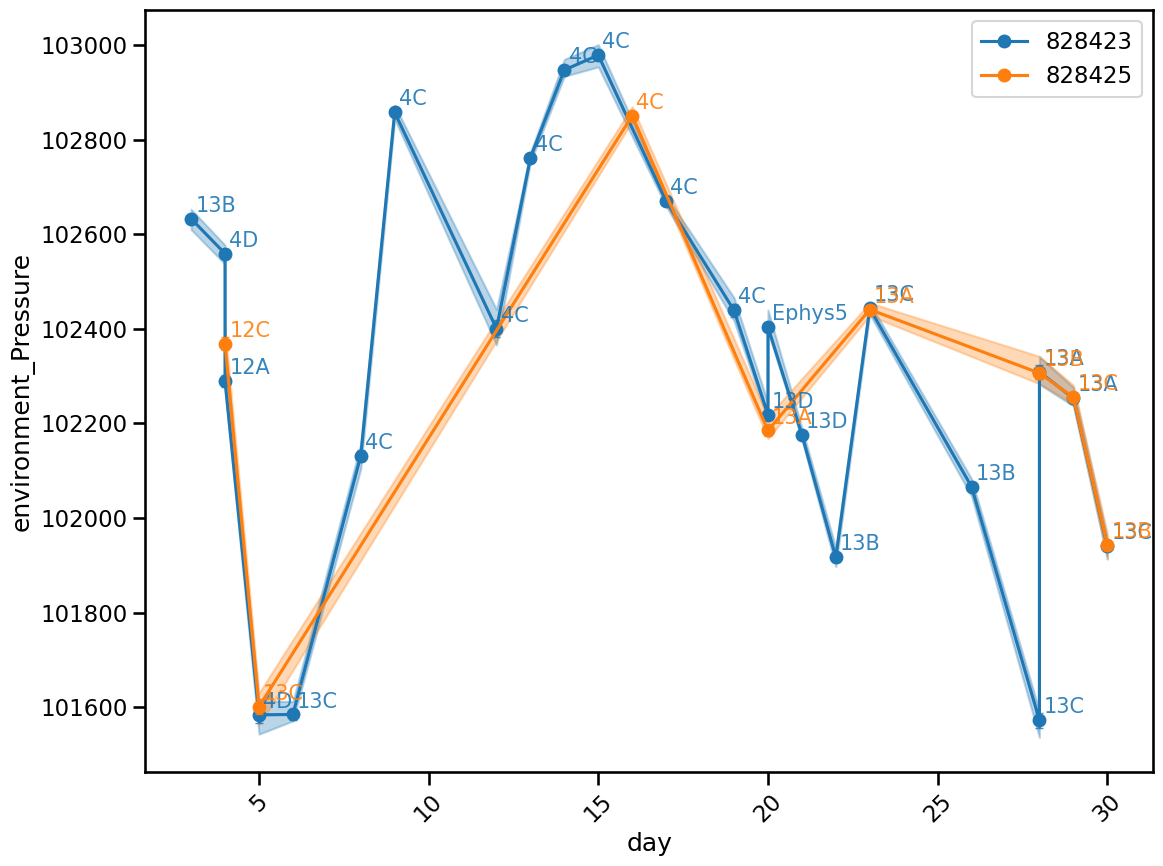

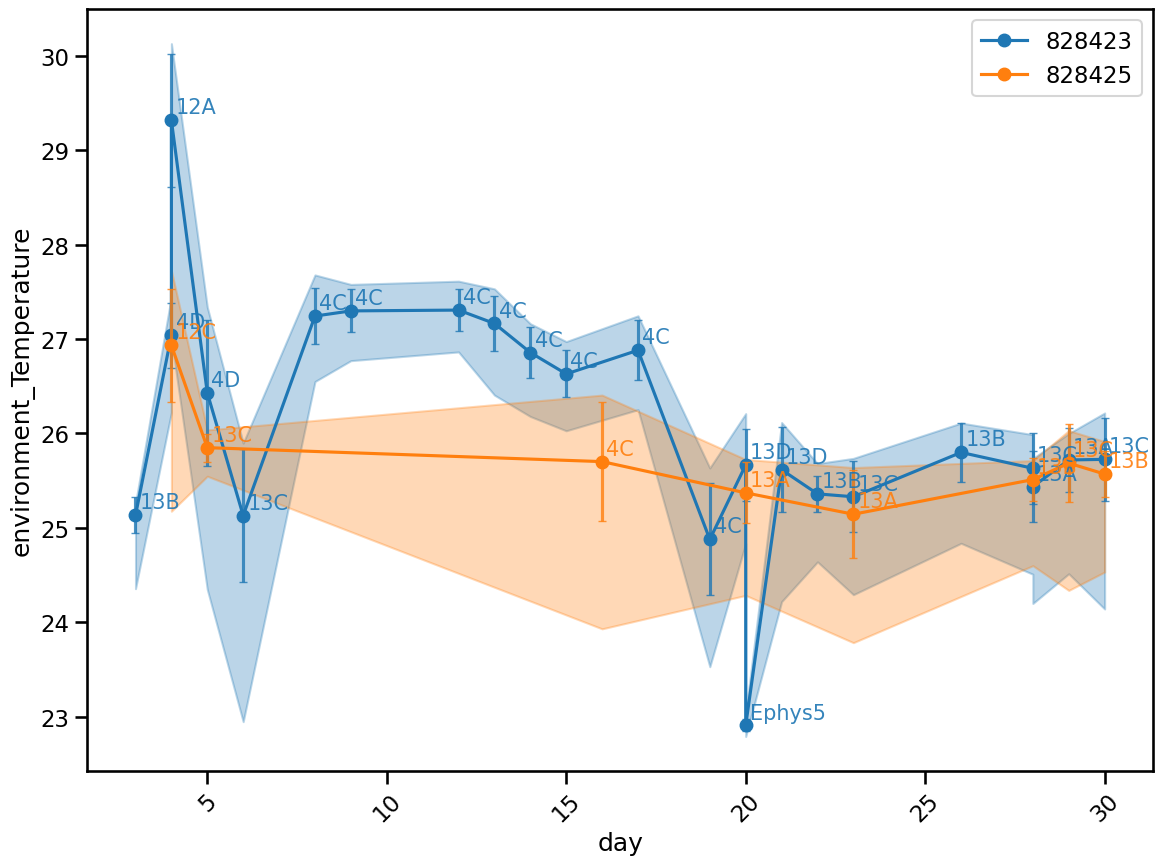

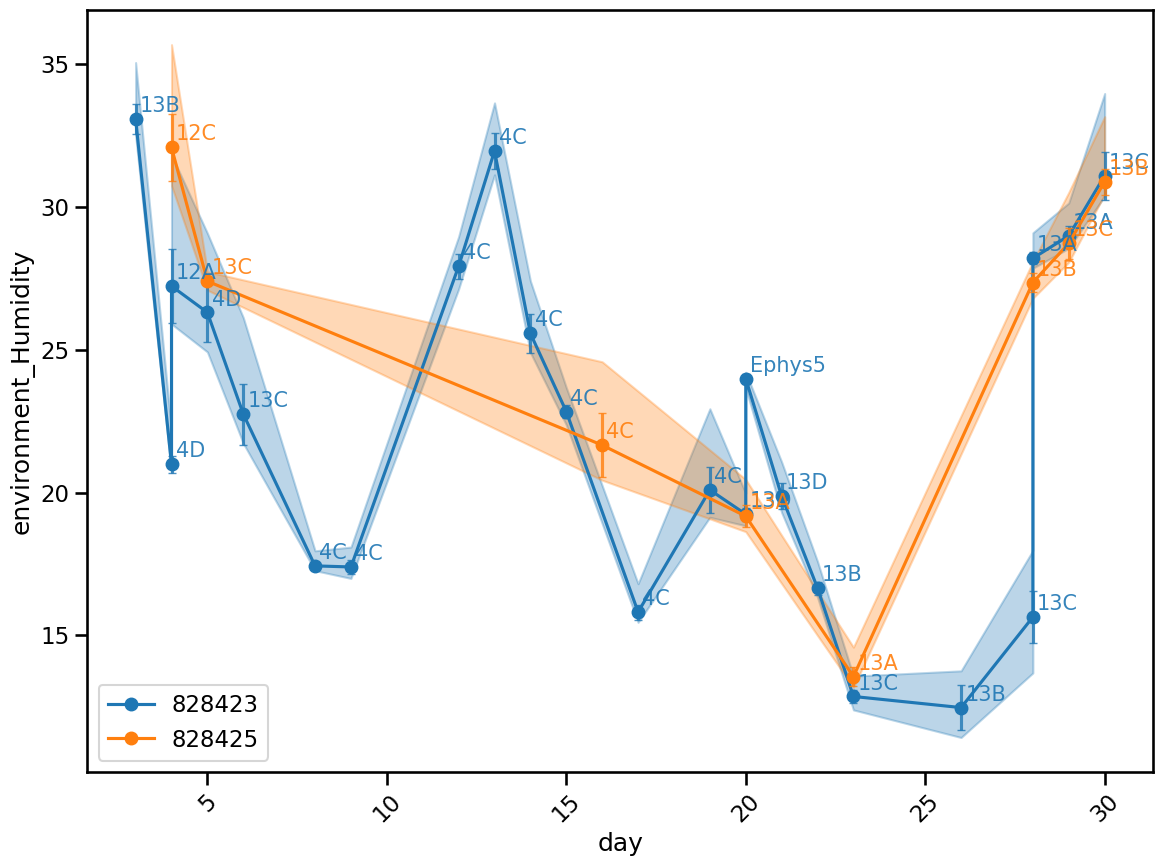

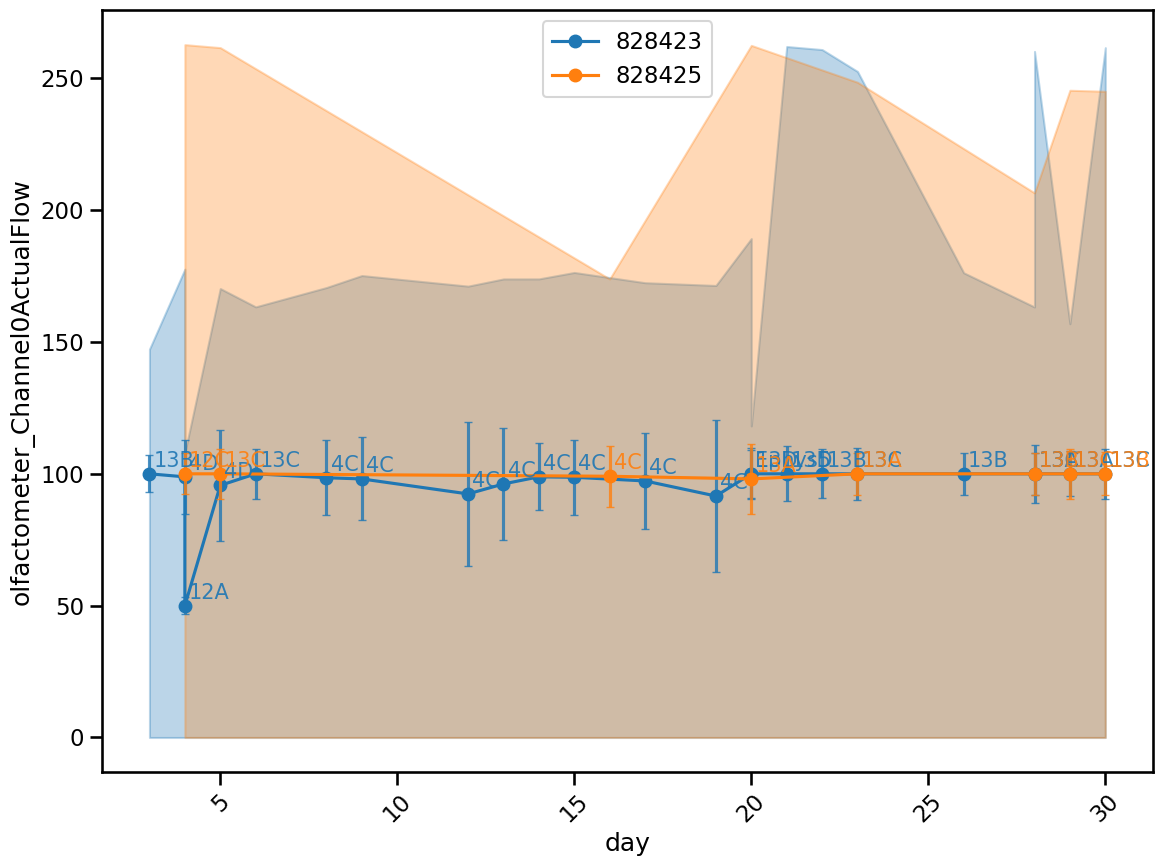

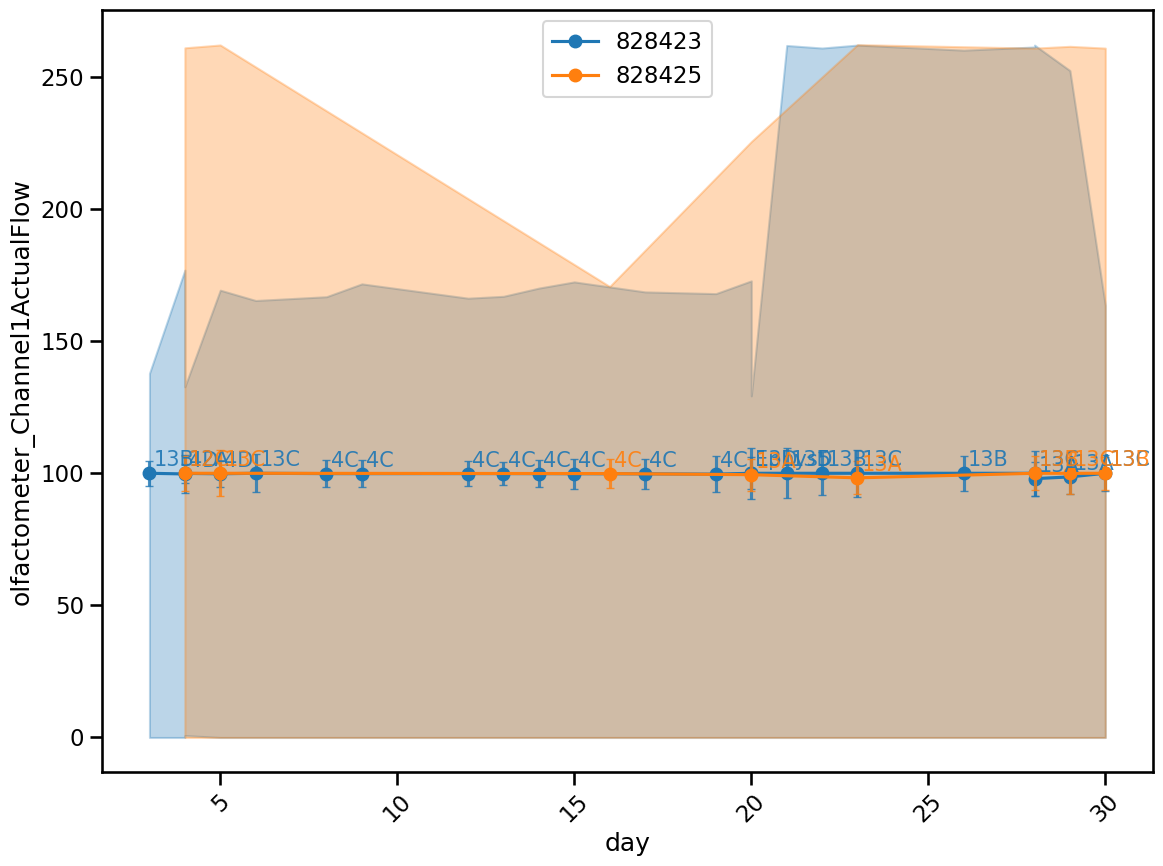

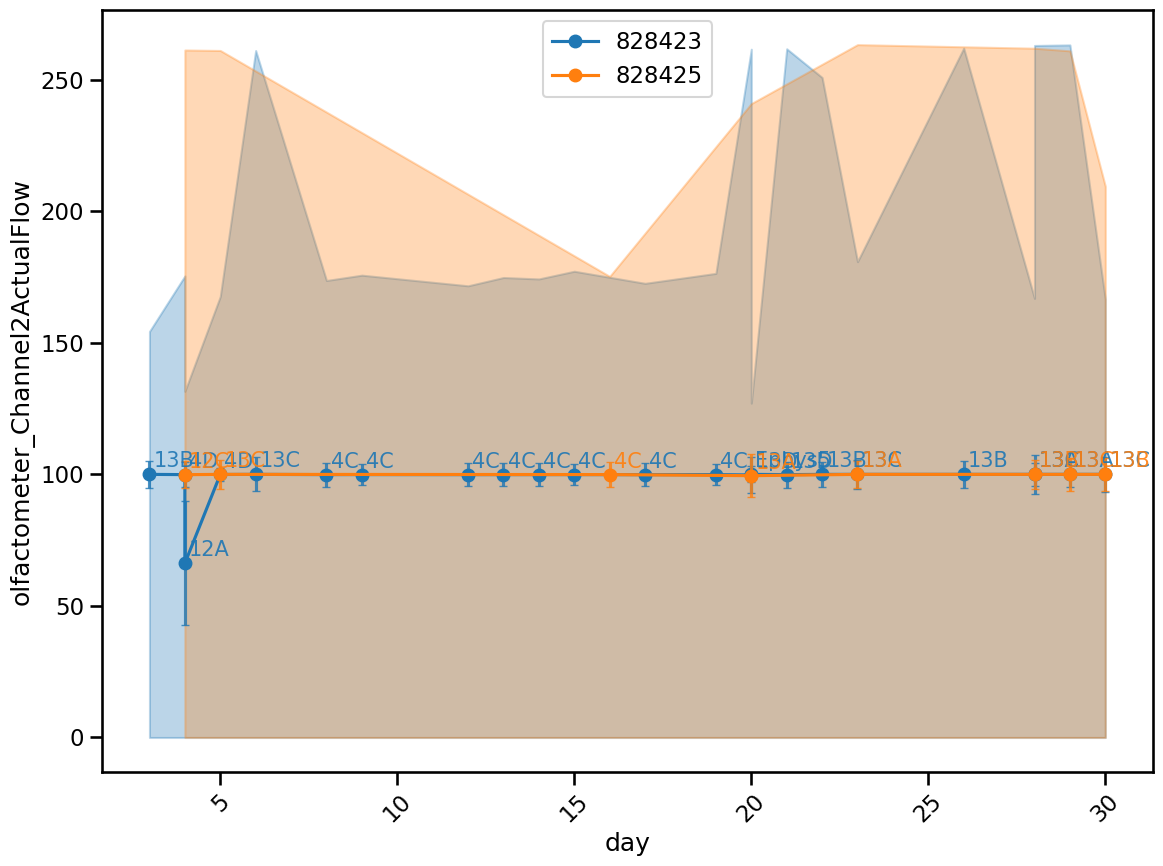

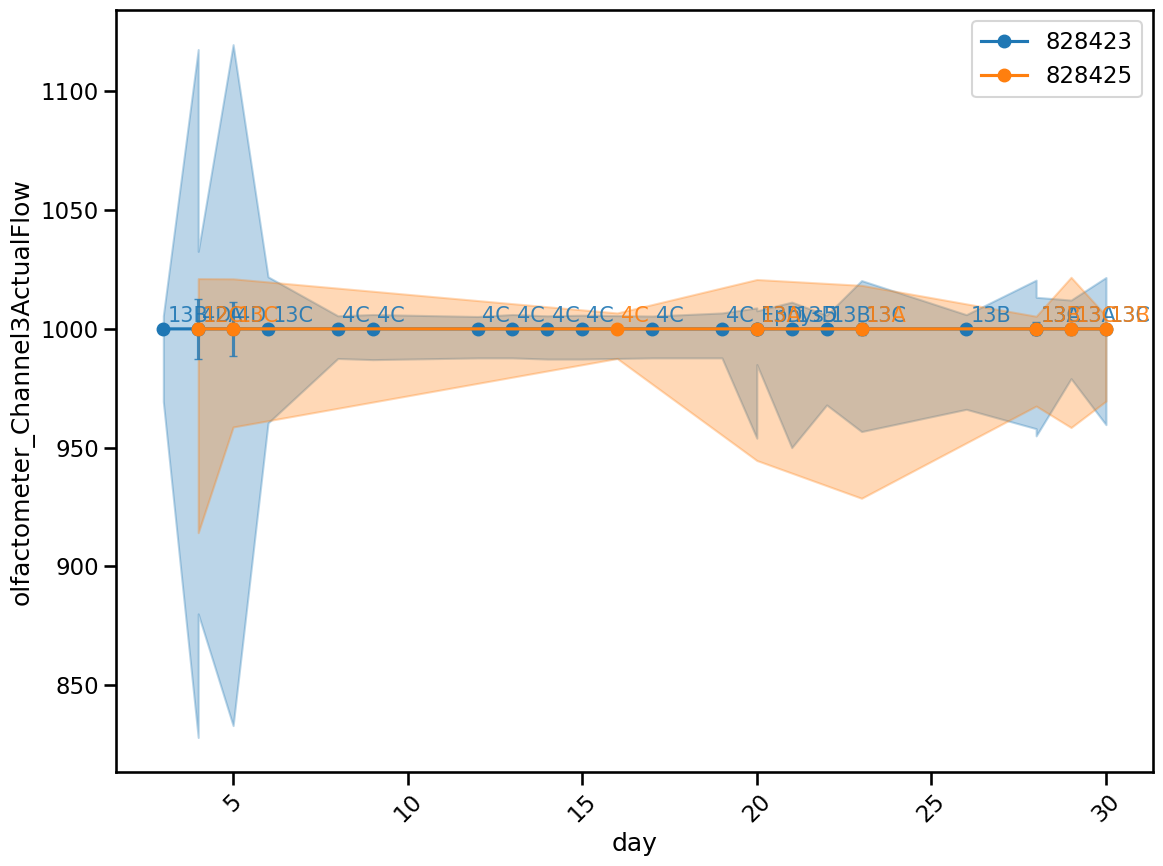

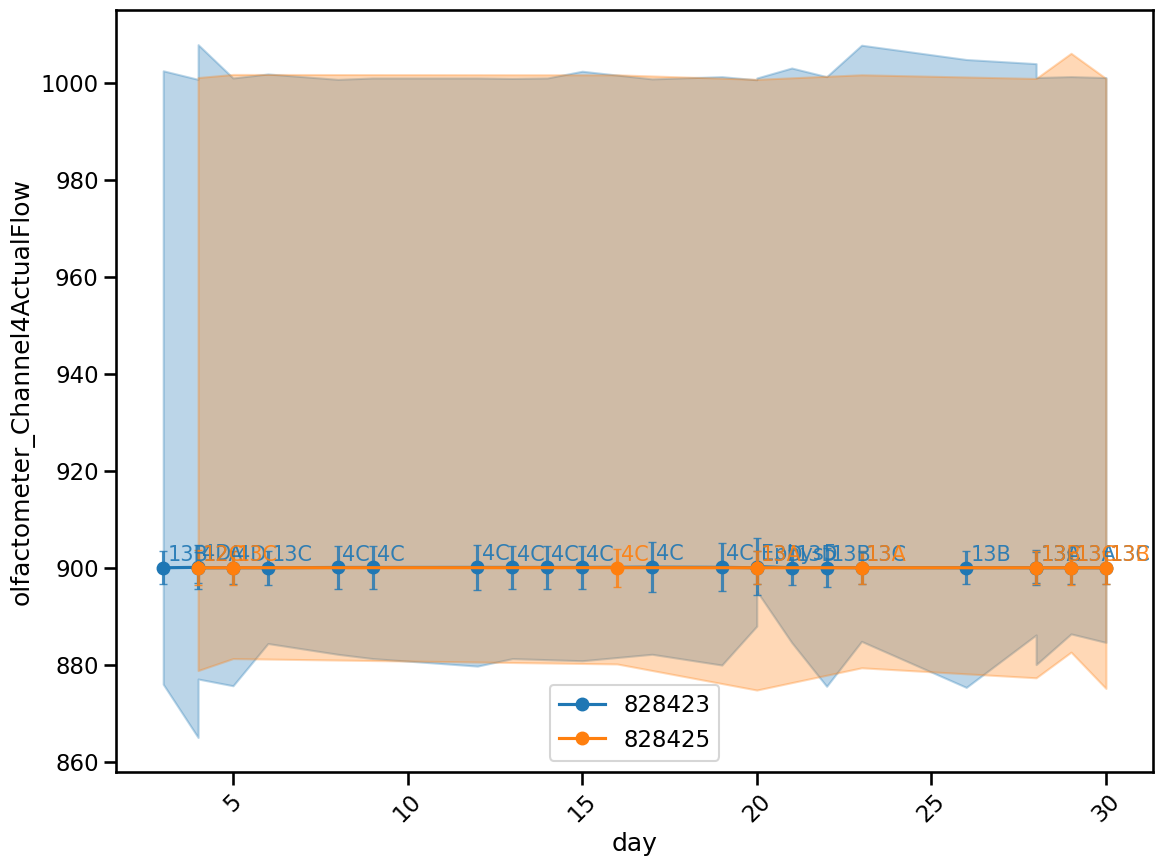

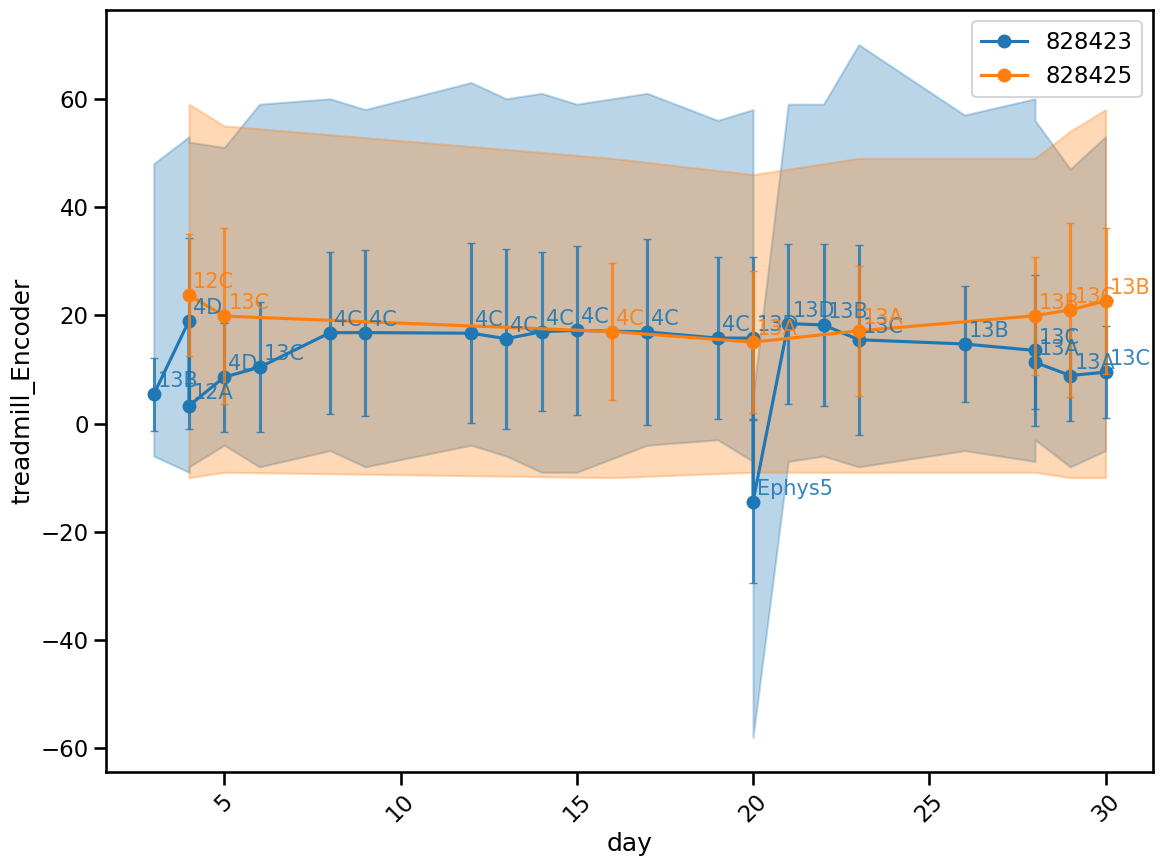

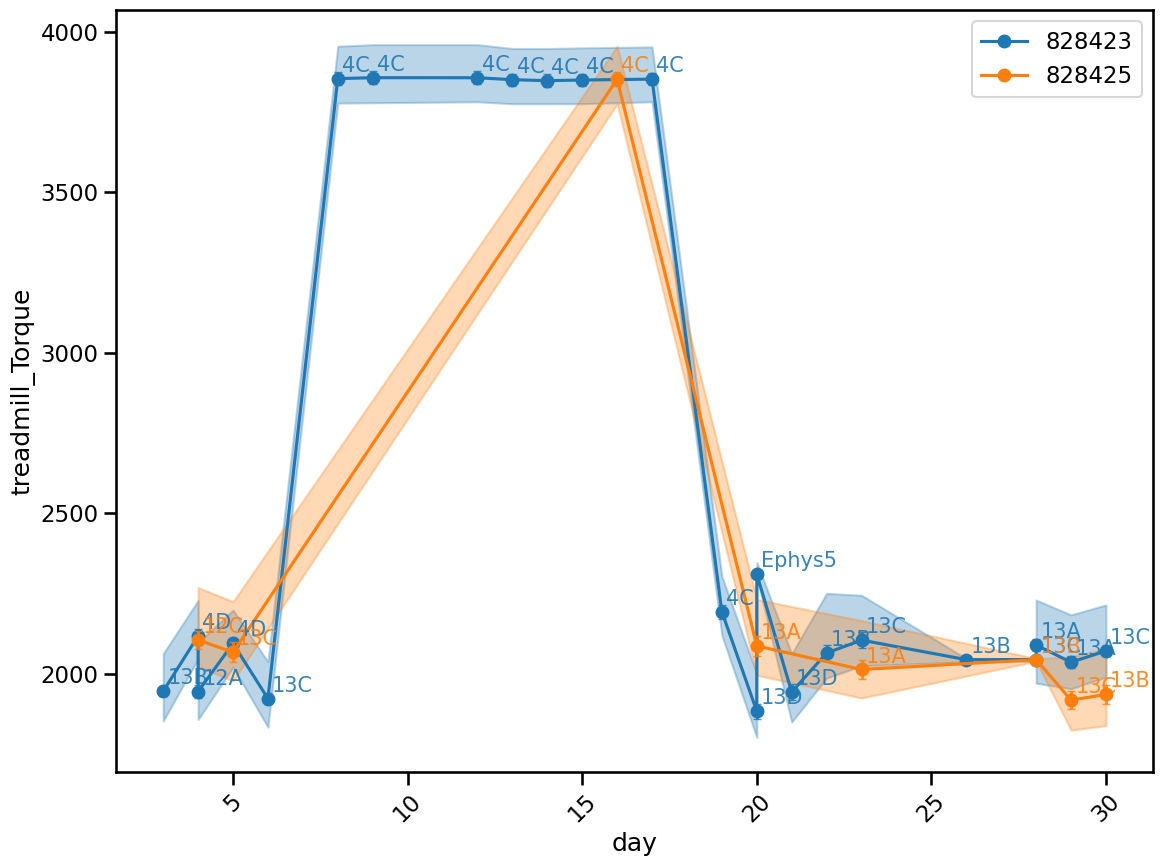

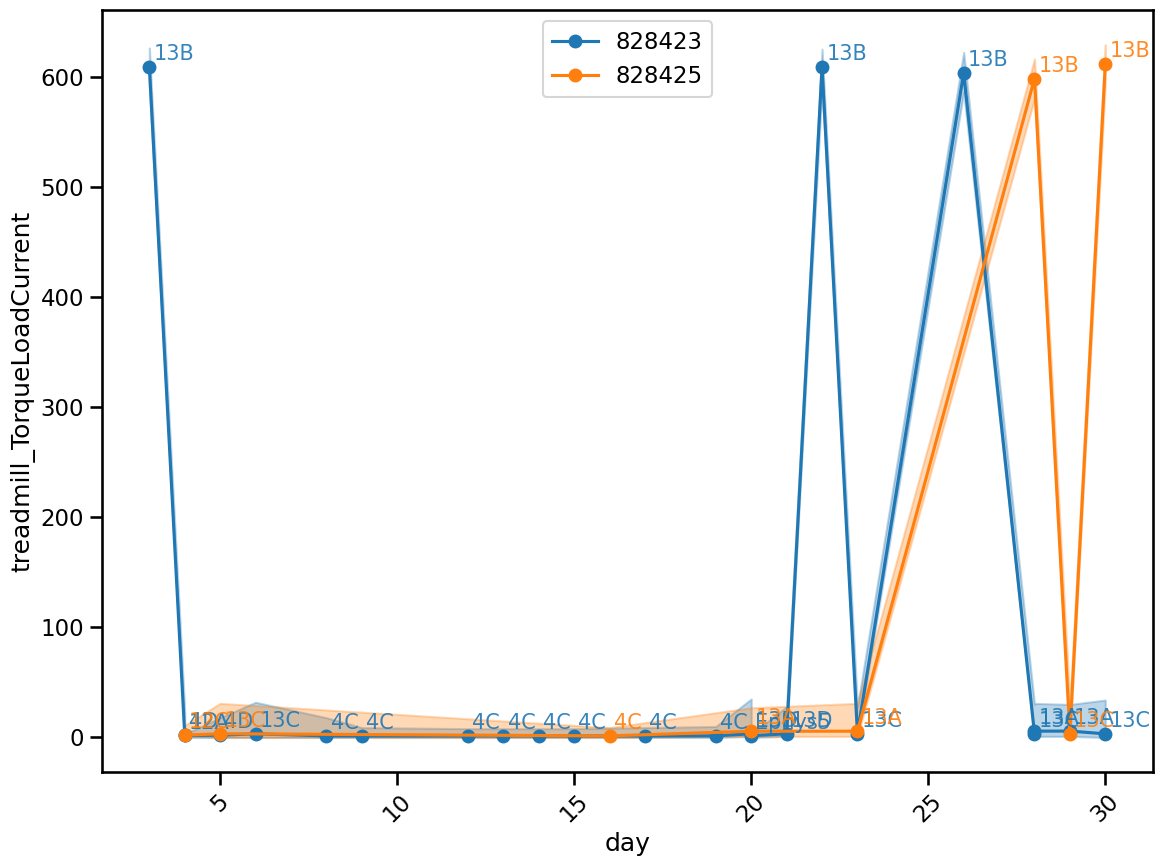

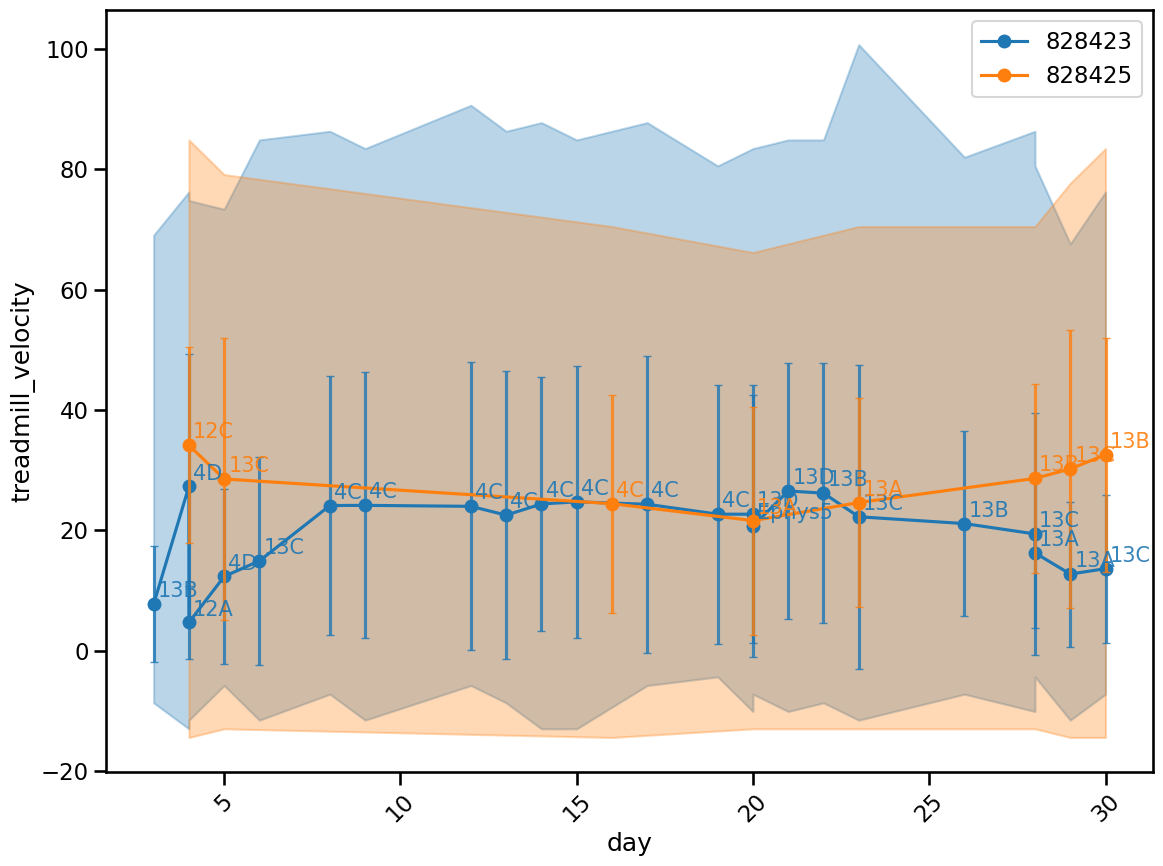

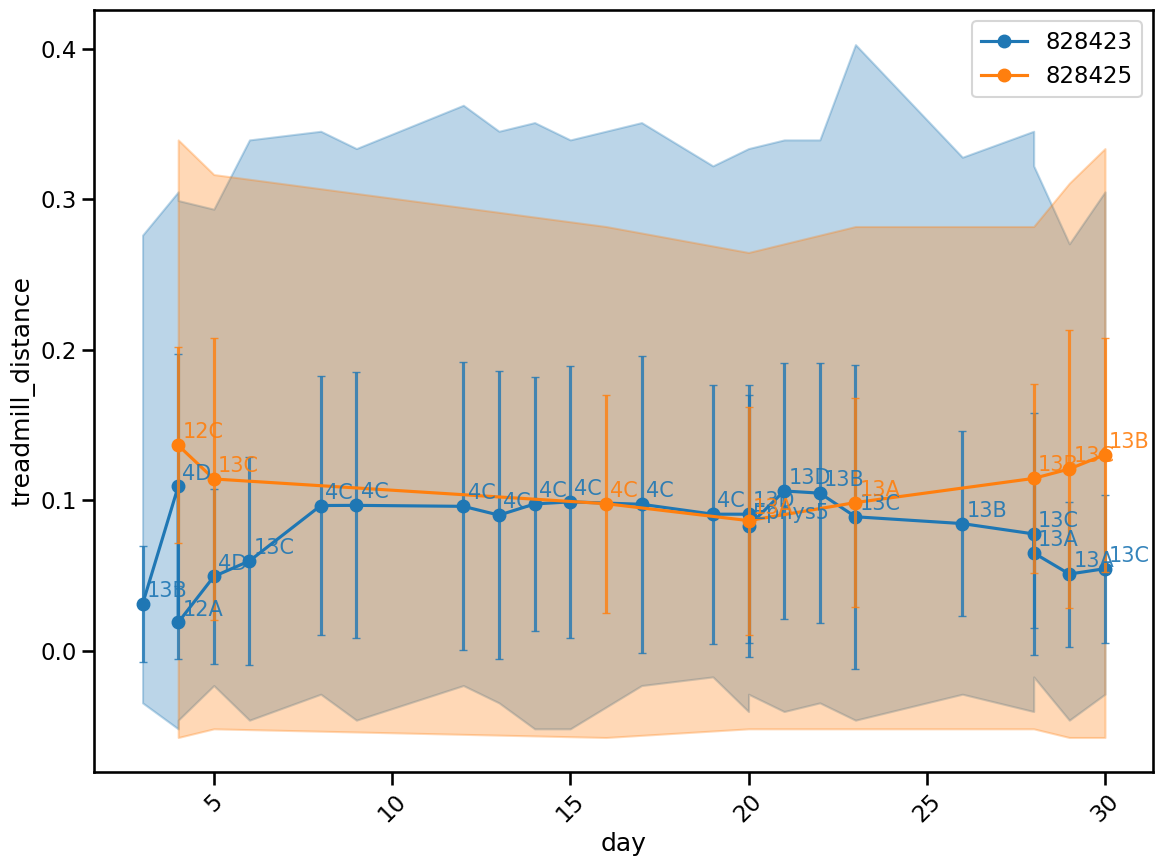

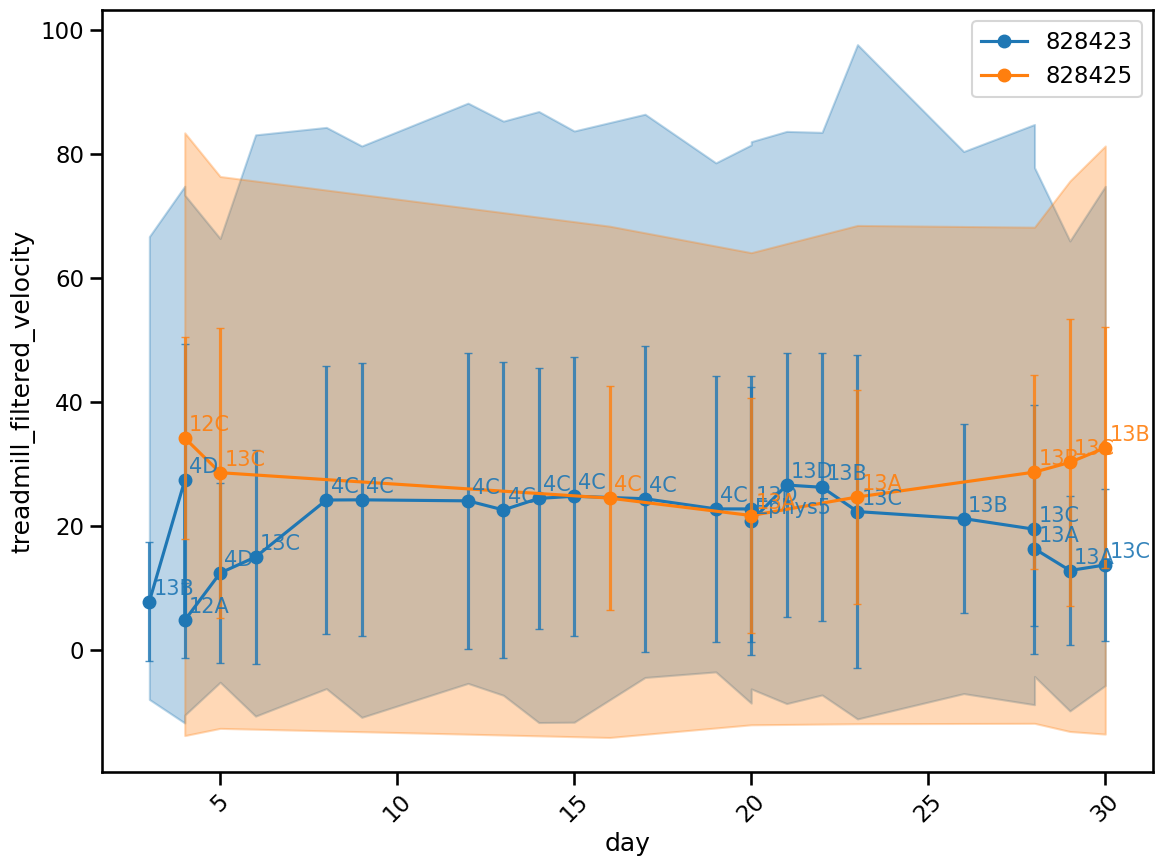

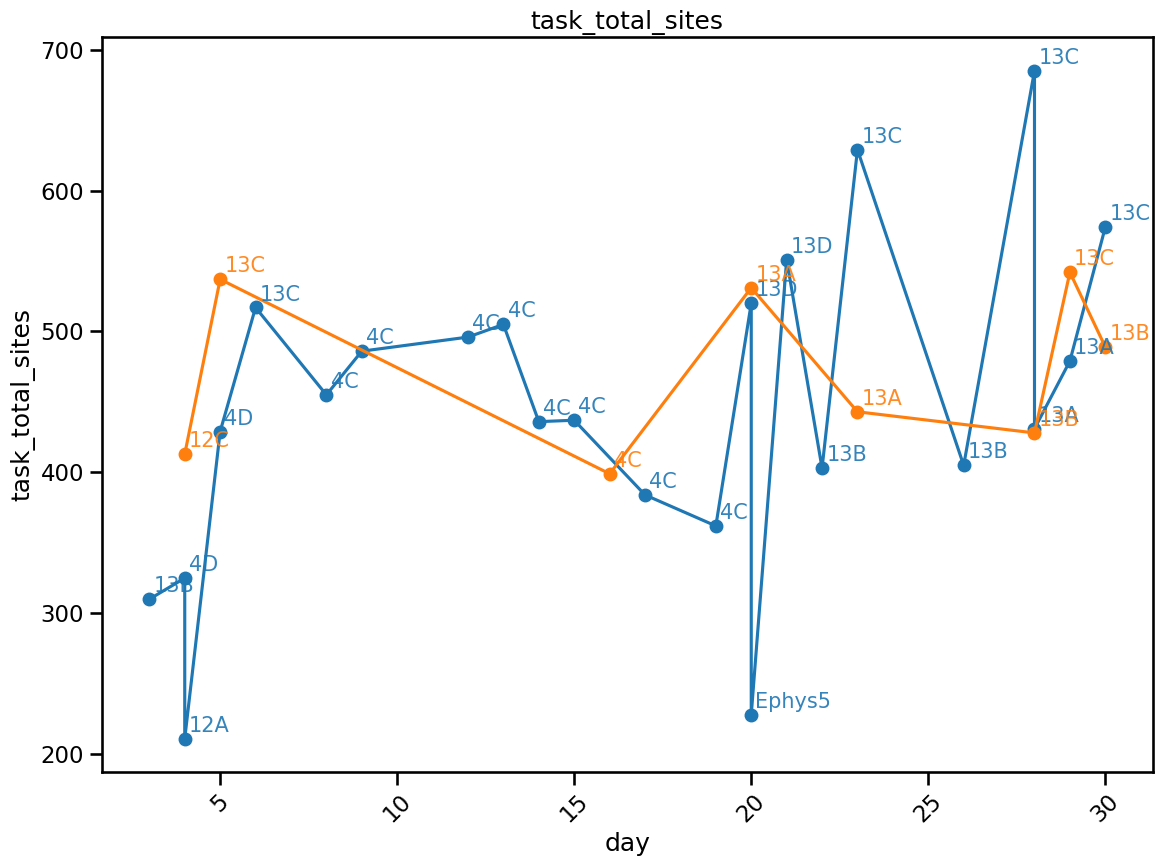

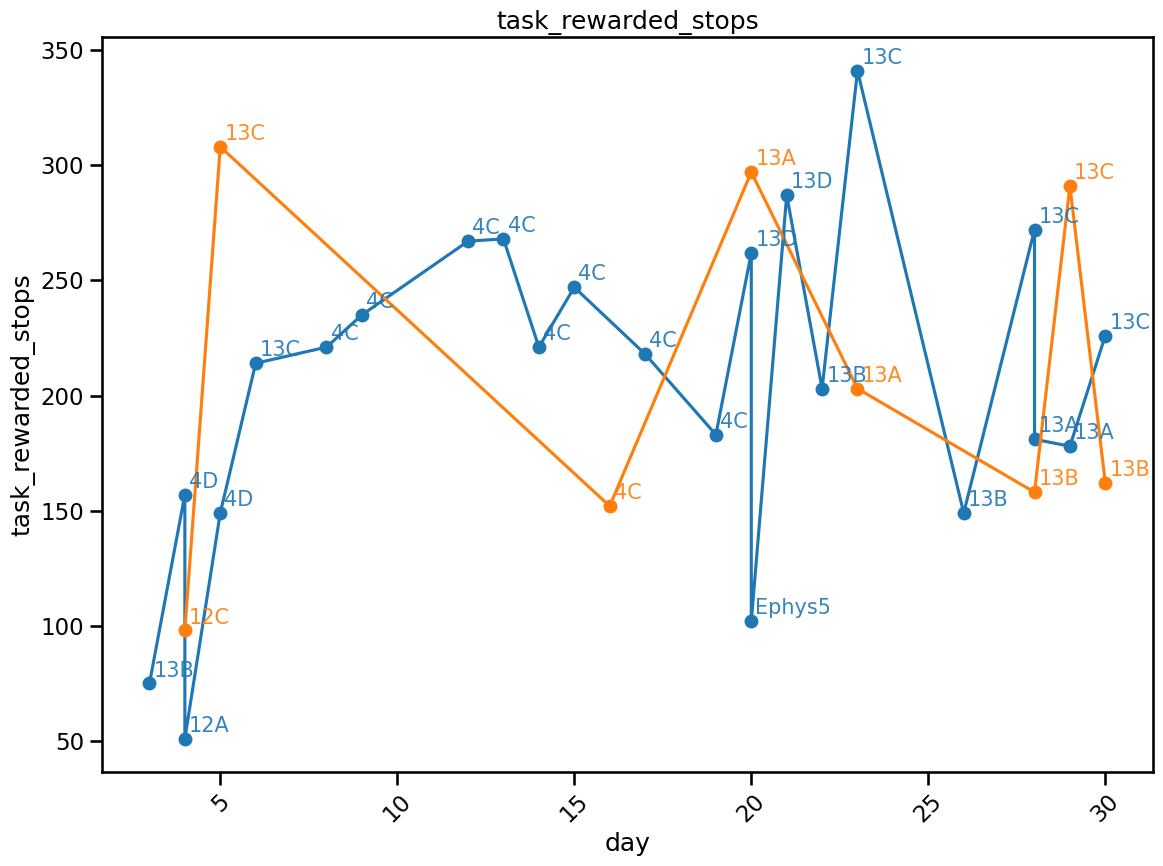

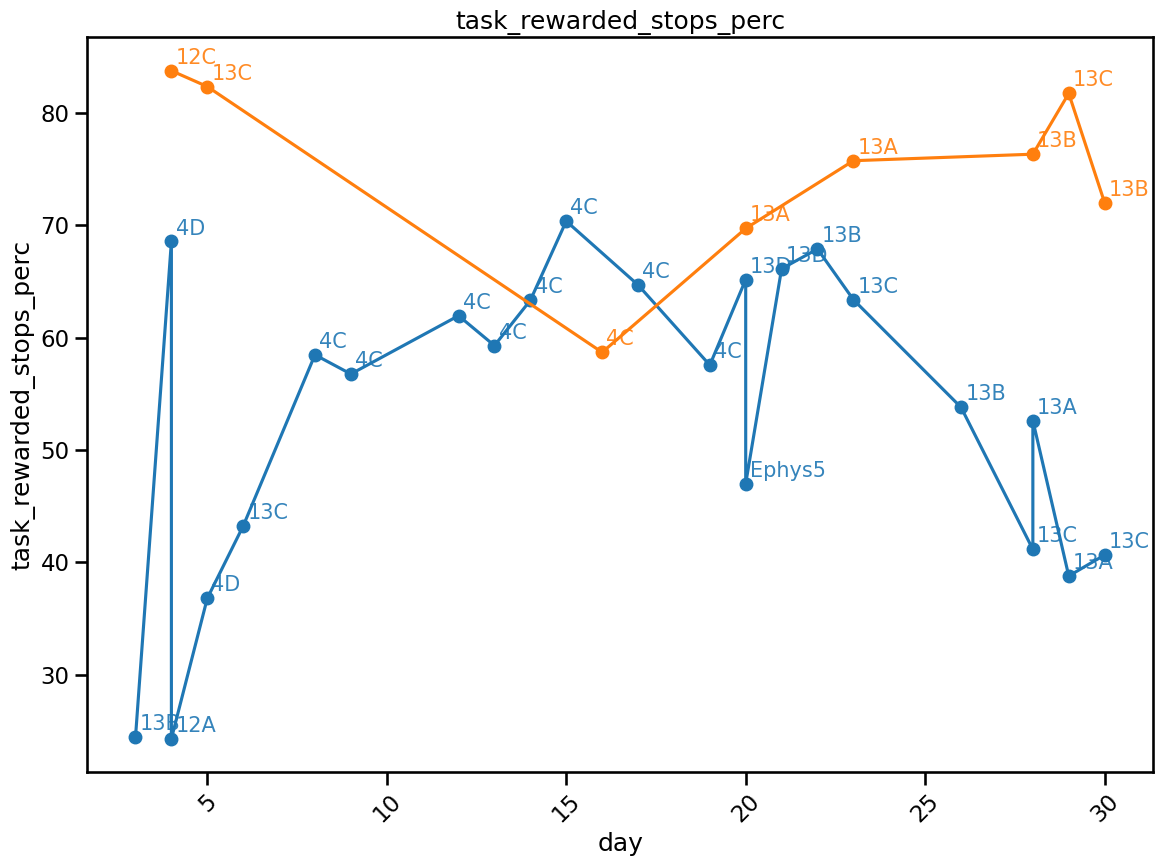

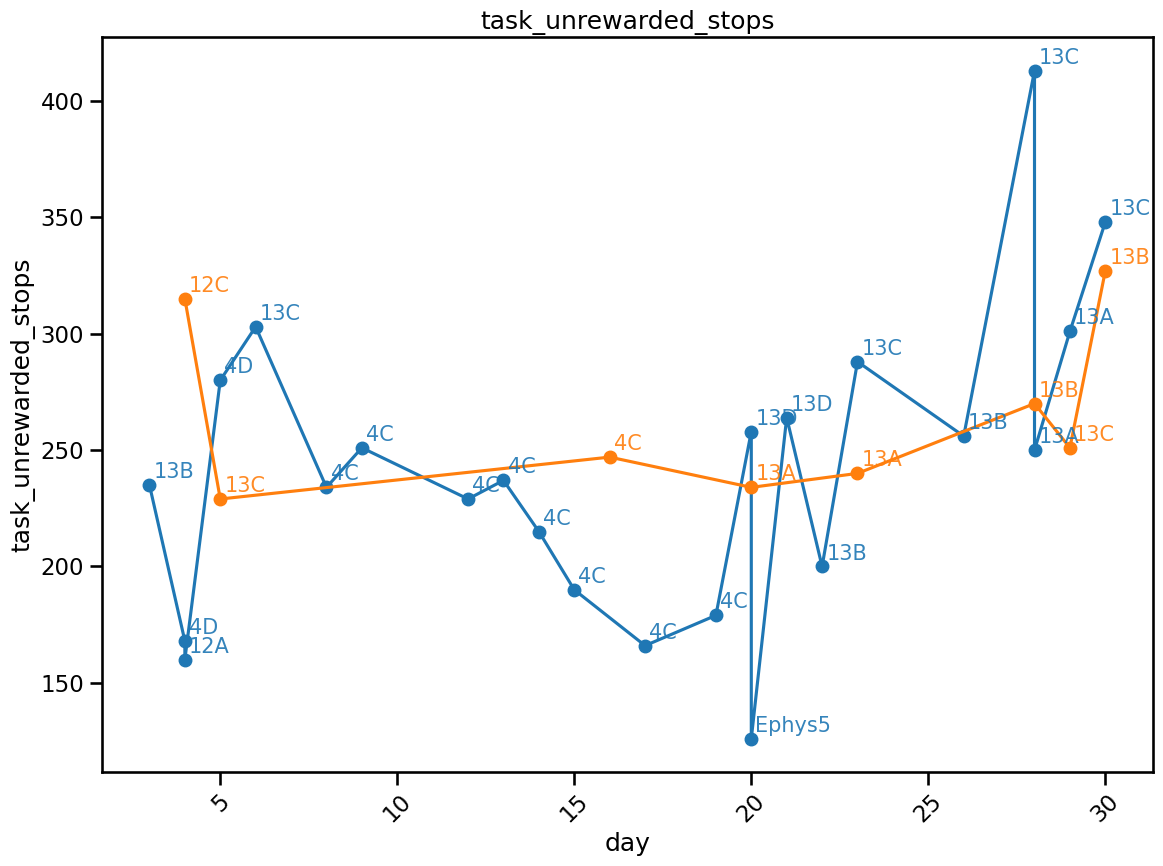

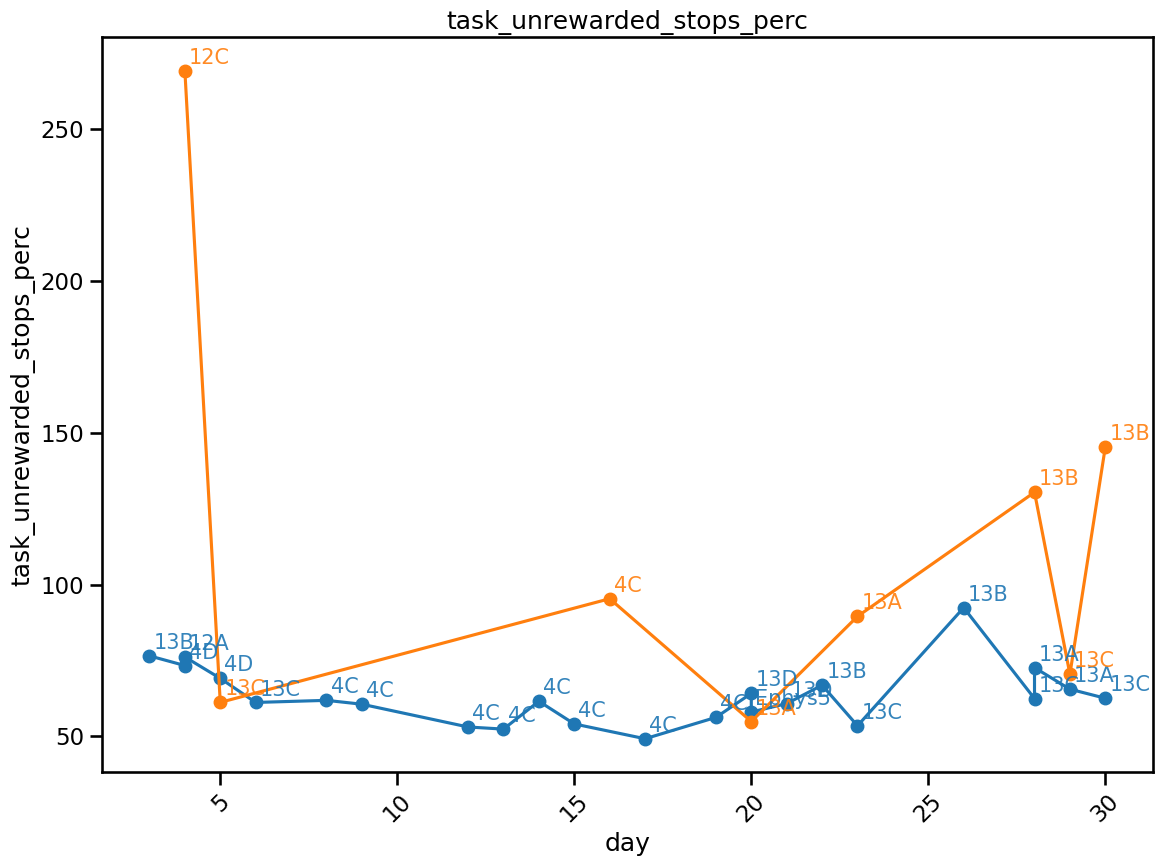

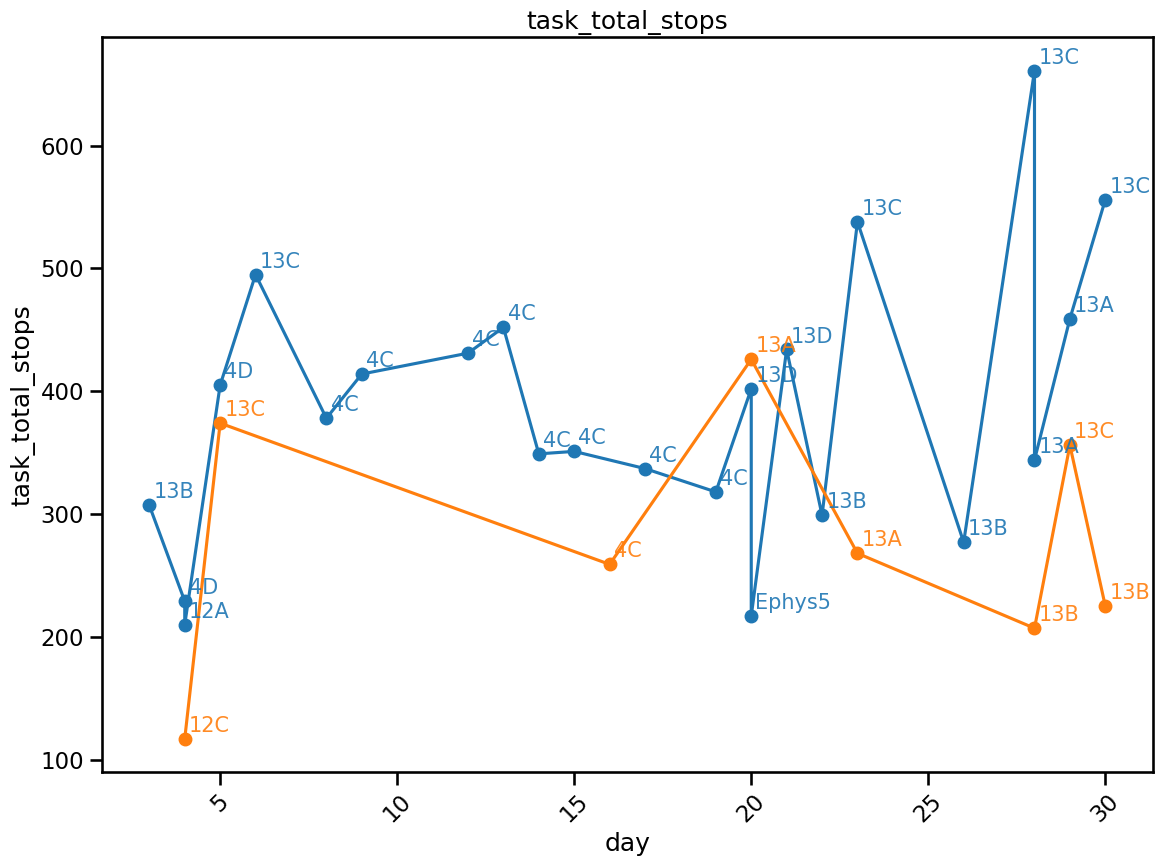

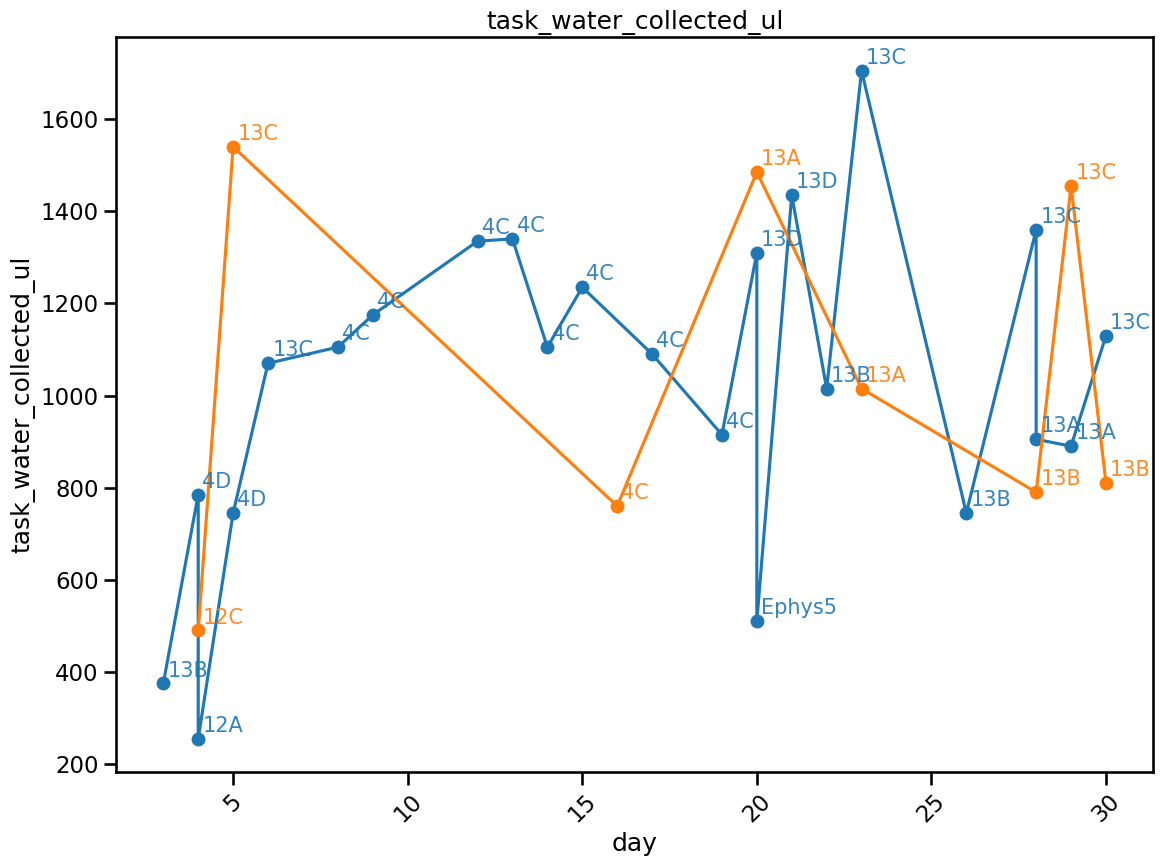

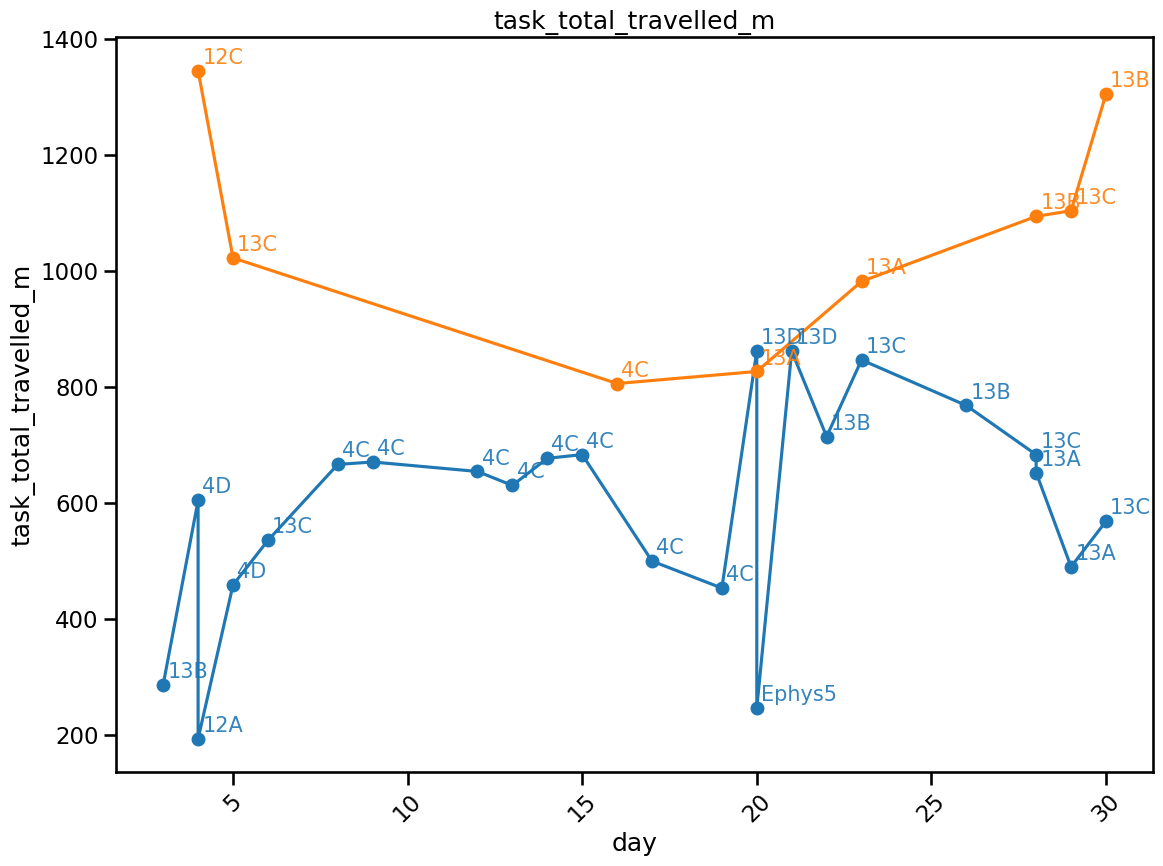

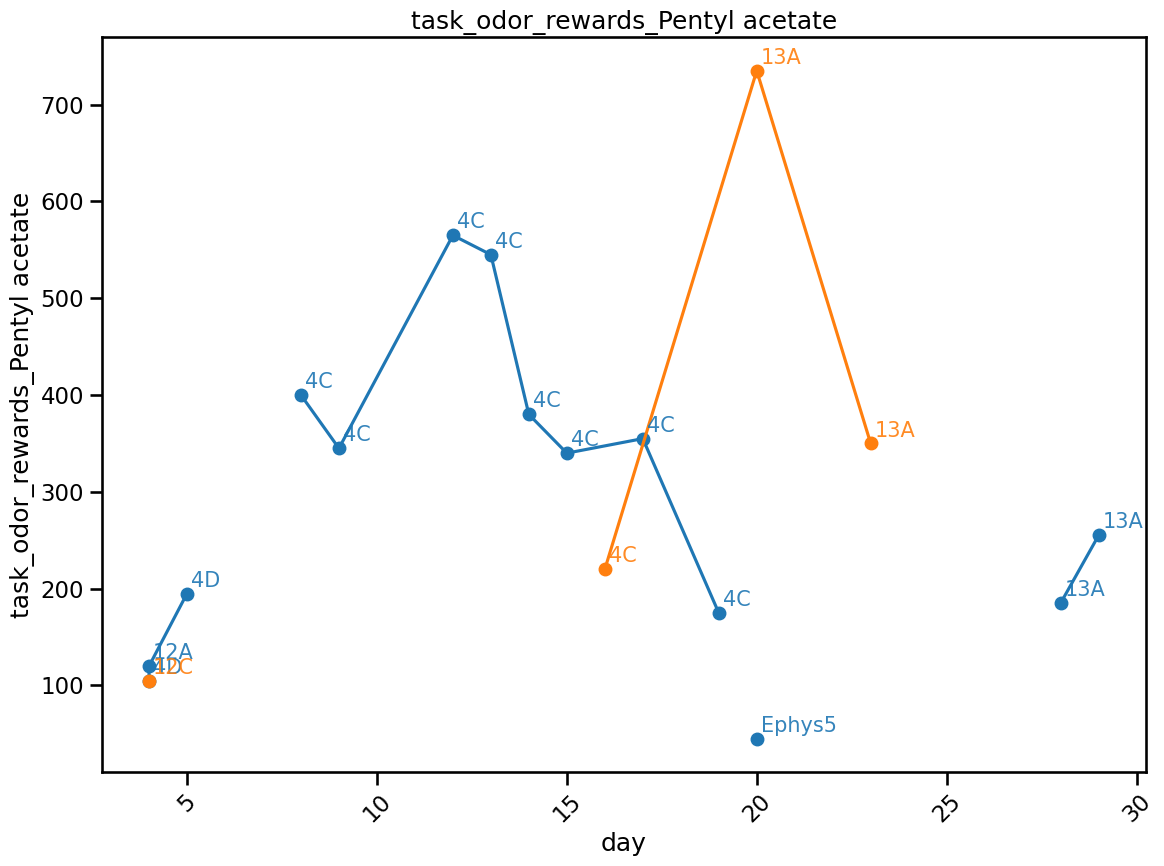

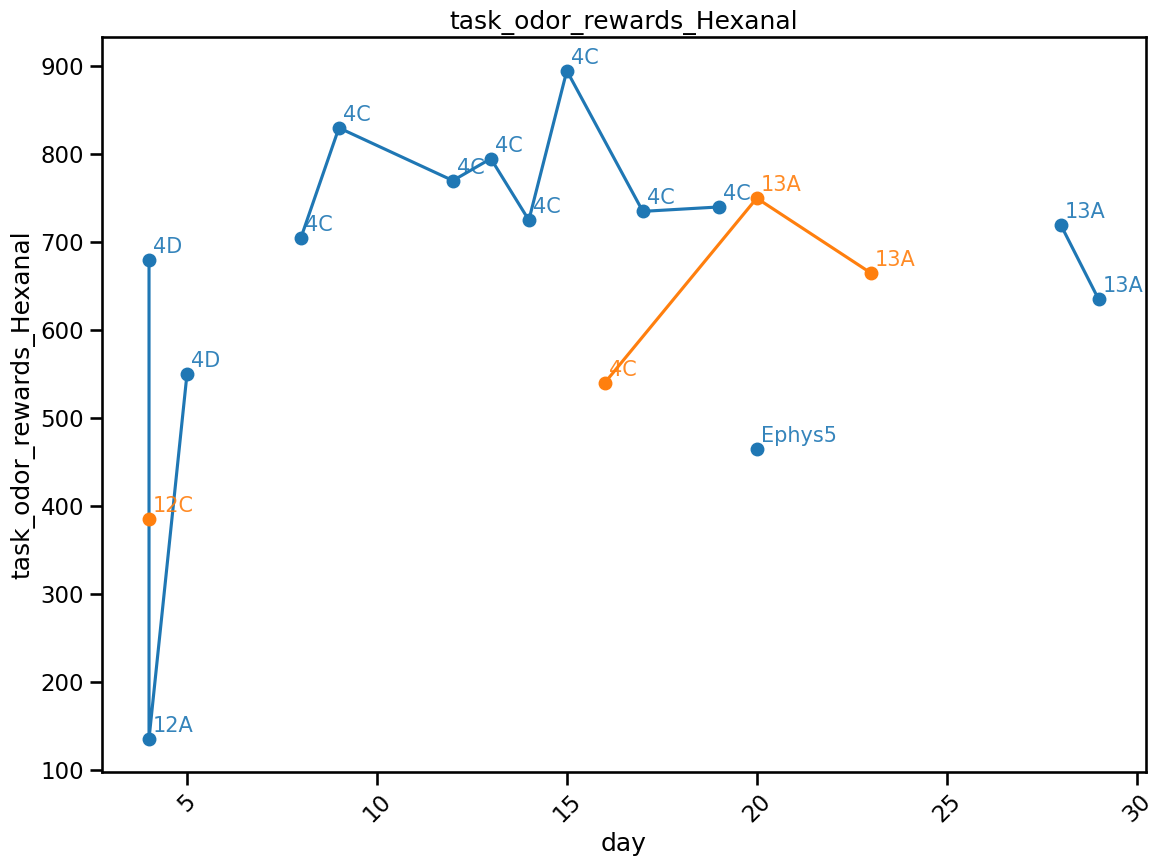

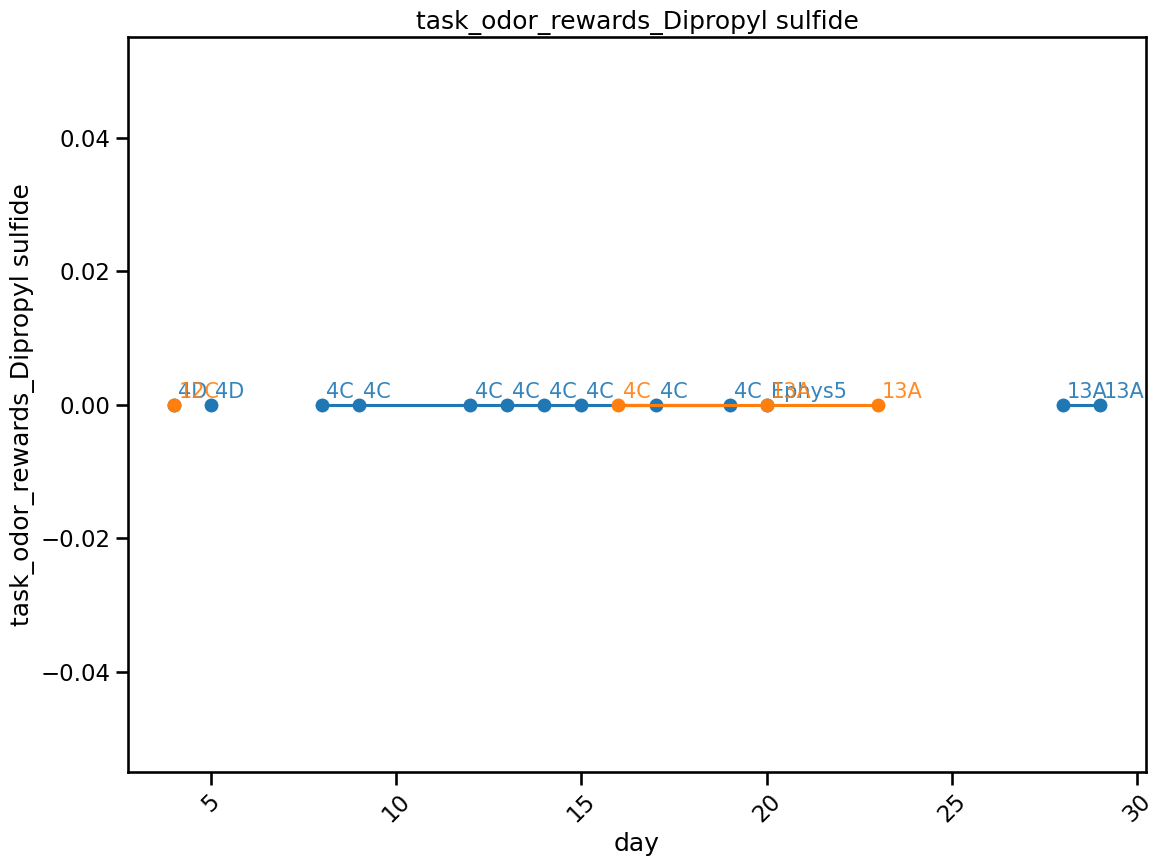

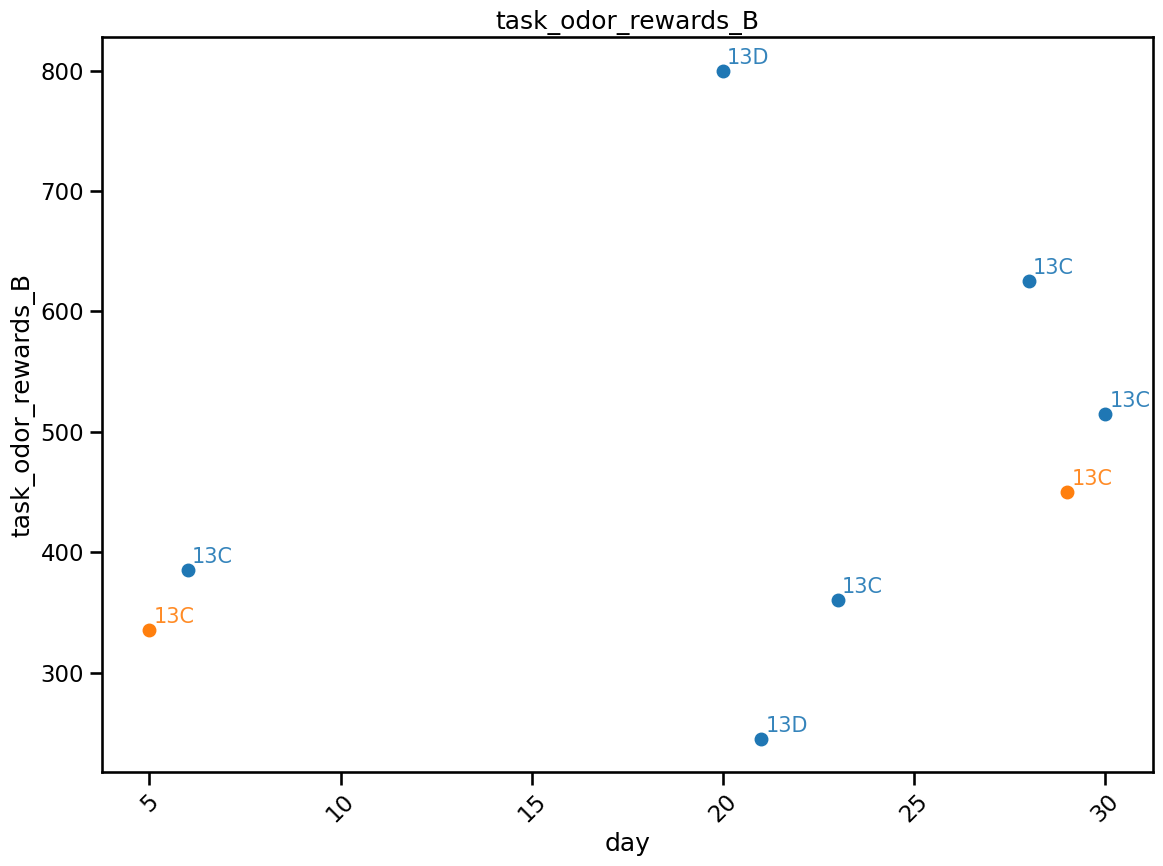

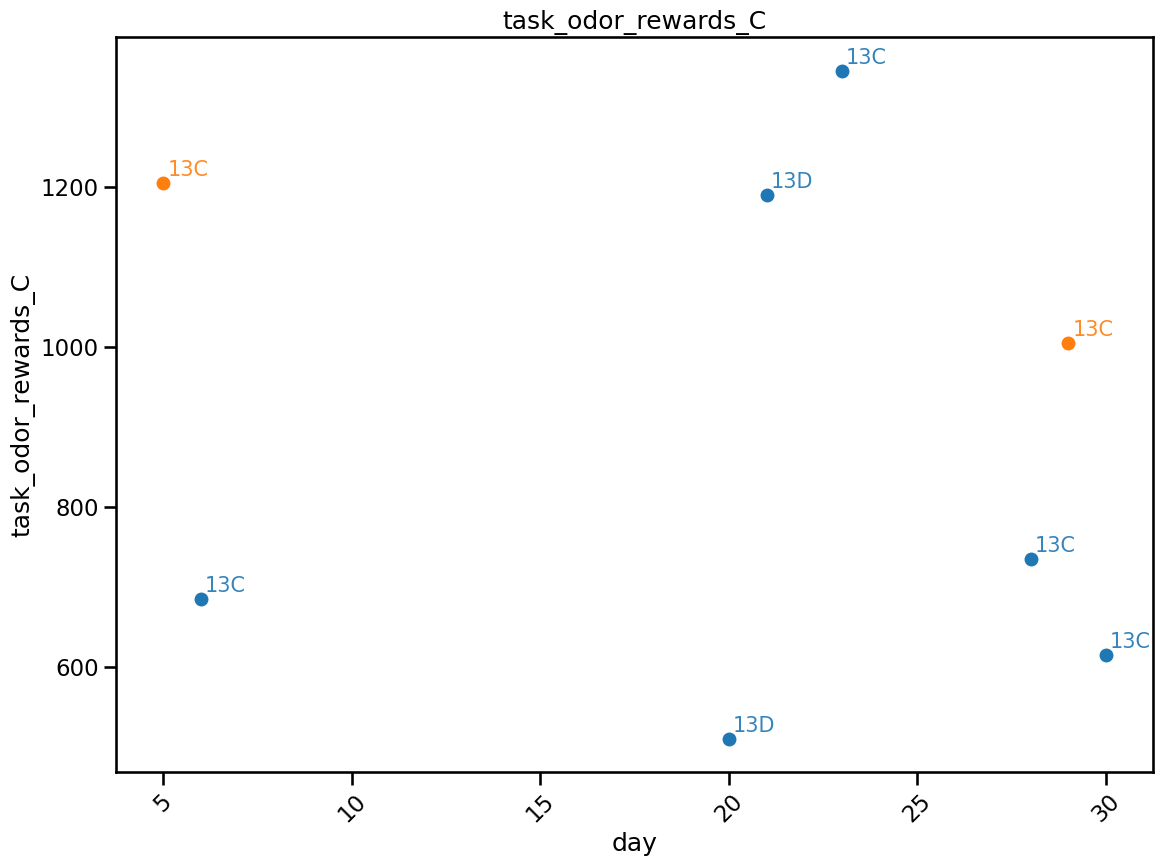

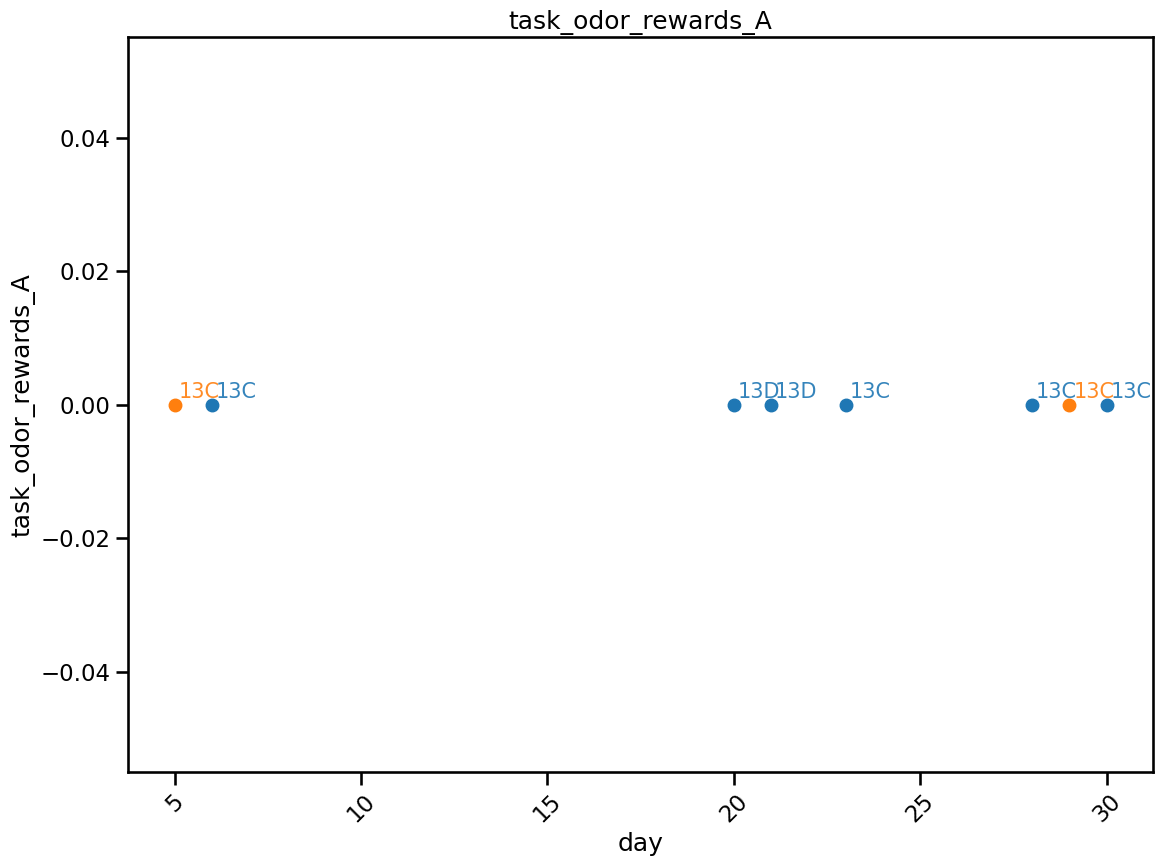

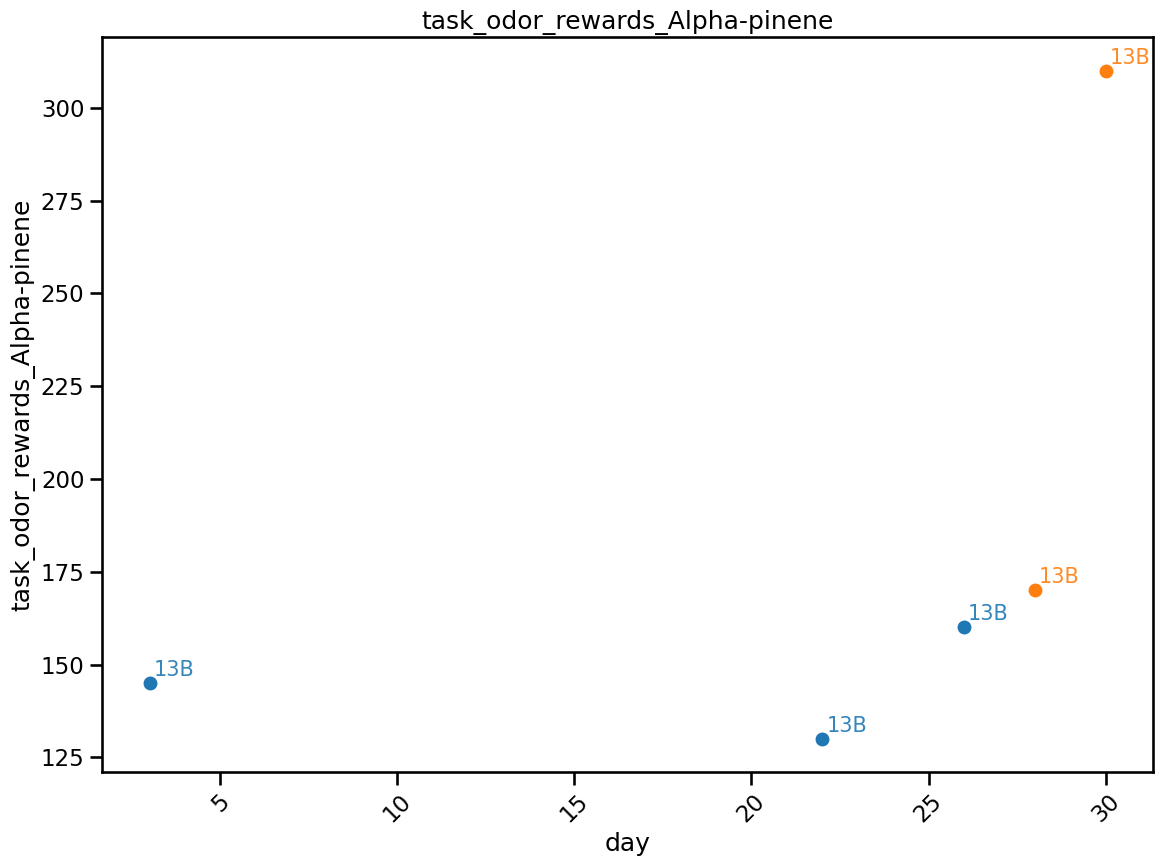

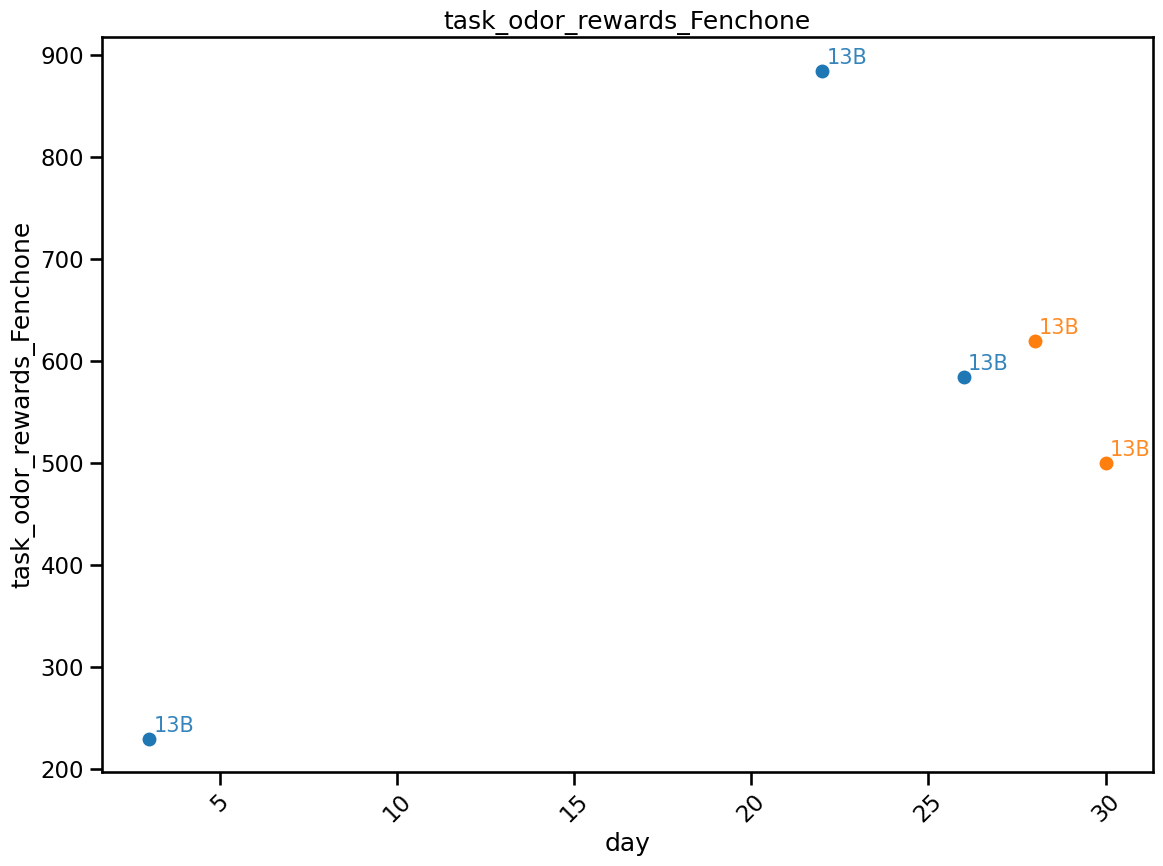

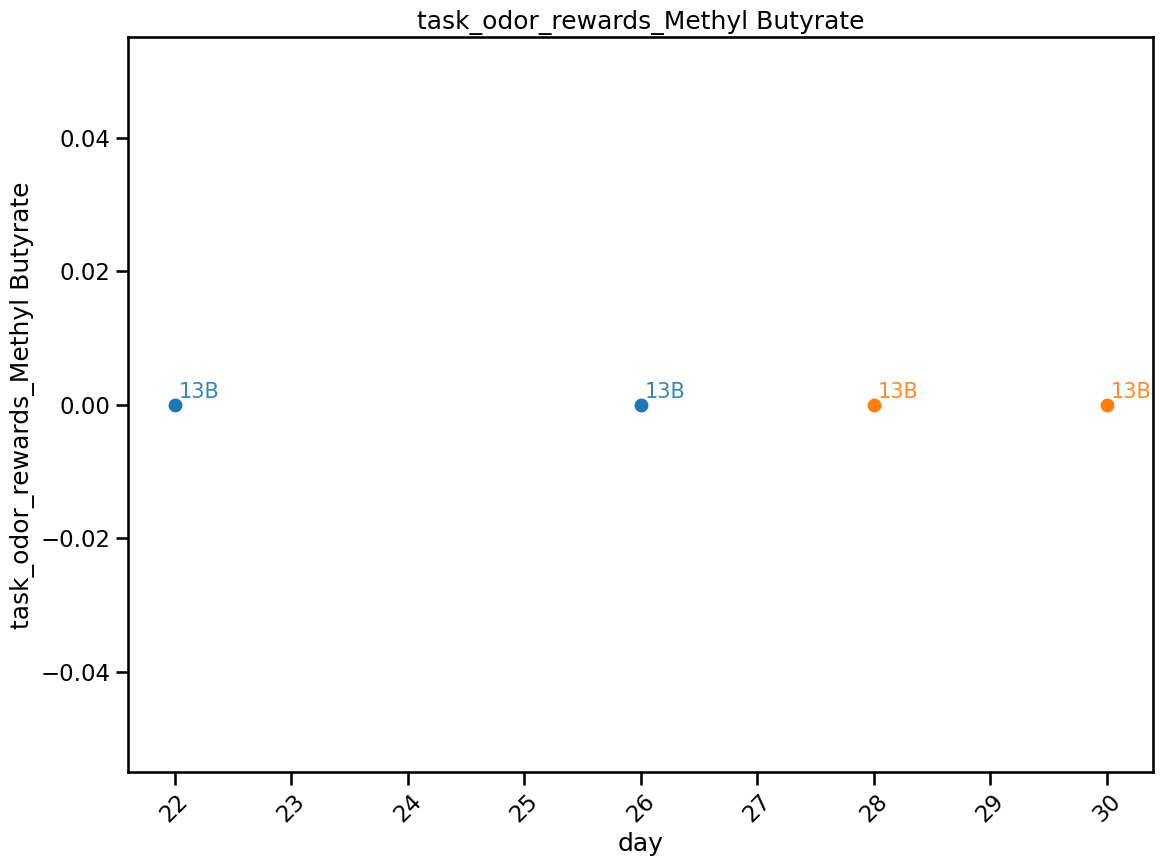

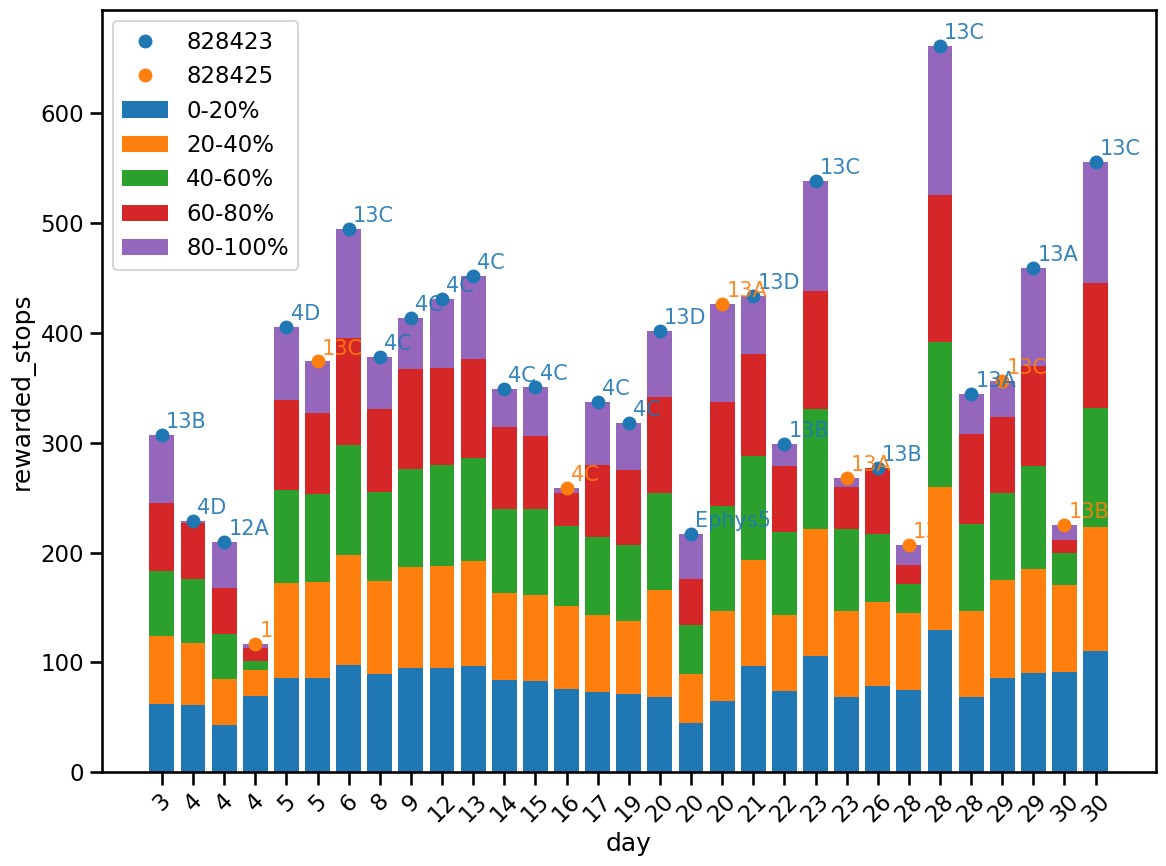

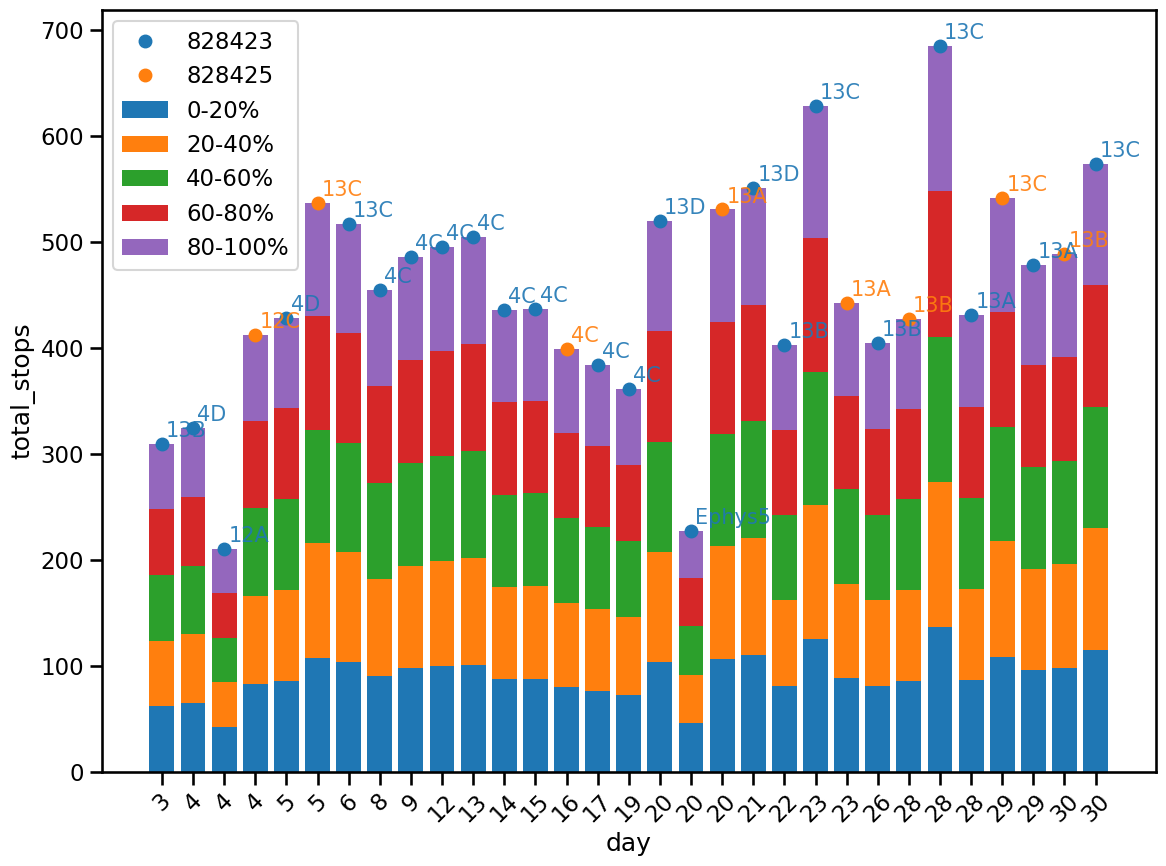

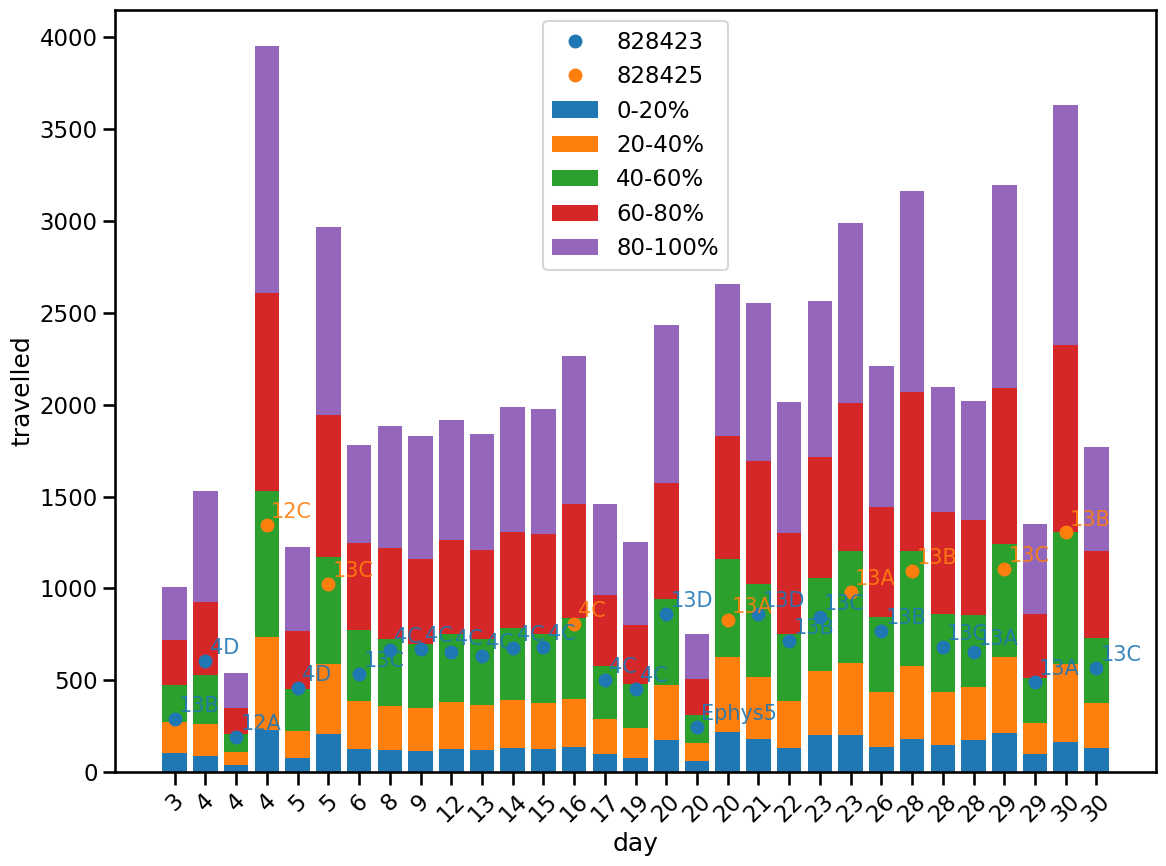

In [84]:
dir = Path(r"C:/Data/")
tests_dir = Path(os.path.join(dir, "Tests"))
save_img_path = os.path.join(dir, "img/") # Comment to skip saving

# Load Summaries
def load_json_summaries(tests_dir):
    
    def flatten_json(d, parent_key="", sep="_"):
        items = []
        for k, v in d.items():
            new_key = f"{parent_key}{sep}{k}" if parent_key else k

            if isinstance(v, dict):
                items.extend(flatten_json(v, new_key, sep=sep).items())
            else:
                items.append((new_key, v))

        return dict(items)
    
    rows = []
    for session_dir in tests_dir.iterdir():
        acq_file = session_dir / "acquisition.json"
        acq_file2 = session_dir / "acquisition_vrforaging.json"
        summary_file = session_dir / "summary.json"

        if not summary_file.exists():
            continue
        
        if acq_file.exists():
            with open(acq_file) as f:
                acq = json.load(f)
        elif acq_file2.exists():
            with open(acq_file2) as f:
                acq = json.load(f)    
        else:
            continue  
        
        with open(summary_file) as f:
            summary = json.load(f)

        # --- Session time ---
        start = pd.Timestamp(acq["acquisition_start_time"])
        end = pd.Timestamp(acq["acquisition_end_time"])
        duration_min = (end - start).total_seconds() / 60
        
        # --- Flatten summary ---
        flat_summary = flatten_json(summary)

        row = {
            "session": session_dir.name,
            "rig": acq["instrument_id"],
            "mouse_n": acq["subject_id"],
            "experimenter": ",".join(acq.get("experimenters", [])),
            "day": start.day,
            "duration_min": round(duration_min, 1),
            **flat_summary
        }
        rows.append(row)
        
    df = pd.DataFrame(rows)
    df = df.sort_values("day")
    df["session_idx"] = range(len(df))
    return df

# --- Plotting Helpers ---
def annotate_points(ax, x, y, tags, fontsize=15, color='black'):
    if tags is not None:
        for xi, yi, tag in zip(x, y, tags):
            if pd.notna(yi):
                ax.annotate(str(tag), (xi, yi), textcoords="offset points", xytext=(3, 5), fontsize=fontsize, alpha=0.9, color=color)

# --- Plotting primitives ---
def plot_metric(df, metric, x_col="day", tag_col="rig", save_img_path = None):
    fig, ax = plt.subplots(figsize = (12, 9))
    
    for inst, g in df.groupby("mouse_n"):
        g = g.sort_values(x_col)
        ax.set_title(f"{metric}")
        x, y = g[x_col], g[metric]
        line, = ax.plot(x, y, marker="o")
        color = line.get_color()
        if tag_col in g: annotate_points(ax, x, y, g[tag_col], color=color)
    
    ax.set_xlabel(x_col)
    ax.set_ylabel(metric)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    if save_img_path: 
        fig.savefig(os.path.join(save_img_path, f"m_{metric}"), dpi=250, bbox_inches='tight')

def plot_family(df, metric, cols, x_col="day", tag_col="rig", save_img_path=None):
    fig, ax = plt.subplots(figsize = (12, 9)) 

    for inst, g in df.groupby("mouse_n"):
        g = g.sort_values(x_col)
        x = g[x_col]
        mean_vals = g[cols["mean"]]
        line, = ax.plot(x, mean_vals, marker="o", label=f"{inst}")
        color = line.get_color()
        if "std" in cols:
            ax.errorbar(x, mean_vals, yerr=g[cols["std"]], fmt="none", ecolor=color, capsize=3, alpha=0.8)
        if "min" in cols and "max" in cols:
            ax.fill_between(x, g[cols["min"]], g[cols["max"]], alpha=0.30, color = color)
        # annotate per mouse line
        if tag_col in g: annotate_points(ax, x, mean_vals, g[tag_col], color=color)
        
    ax.set_xlabel(x_col)
    ax.set_ylabel(metric)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
    if save_img_path: 
        fig.savefig(os.path.join(save_img_path, f"a_{metric}"), dpi=250, bbox_inches='tight')

def plot_slices(df, metric, x_col="day", tag_col="rig", save_img_path=None):
    # Slice stacking order (bottom -> top)
    slice_order = ["Slices_0-20%", "Slices_20-40%",  "Slices_40-60%", "Slices_60-80%", "Slices_80-100%"]

    slice_cols = [f"{s}_{metric}" for s in slice_order if f"{s}_{metric}" in df.columns]
    full_col = f"Slices_Full_{metric}"

    if not slice_cols:
        return

    fig, ax = plt.subplots(figsize=(12, 9))
    x = np.arange(len(df[x_col]))
    bottom = np.zeros(len(df))

    # --- Stacked slice bars ---
    for col in slice_cols:
        label = col.replace("Slices_", "").replace("_" + metric, "")
        values = df[col].values
        ax.bar(x, values, bottom=bottom, label=label)
        bottom += values

# --- One FULL line per mouse_n --- 
    if full_col in df.columns and "mouse_n" in df.columns: 
        for mouse, g in df.groupby("mouse_n"): 
            idx = df.index.get_indexer(g.index)            
            line, =ax.plot(idx, g[full_col], marker="o", linestyle="-", linewidth=0, label=f"{mouse}")
            color = line.get_color()
            if tag_col in g.columns: annotate_points(ax, idx, g[full_col].values, g[tag_col], color=color)


    # --- Axis formatting ---
    ax.set_xticks(x)
    ax.set_xticklabels(df[x_col], rotation=45)
    ax.set_xlabel(x_col)
    ax.set_ylabel(metric)

    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # --- Save img ---
    if save_img_path: 
        fig.savefig(os.path.join(save_img_path, f"s_{metric}"), dpi=250, bbox_inches='tight')

# --- Plotting Coordinator ---
def plot_grouped_metrics(df, x_col="day", tag_col="rig", save_img_path=None):
    stats_suffixes = ["mean", "std", "min", "max"]
    families, single_metrics, slice_properties = {}, [], set()

    for col in df.columns:
        for suffix in stats_suffixes:
            if col.endswith("_" + suffix):
                base = col[:-(len(suffix) + 1)]
                families.setdefault(base, {})[suffix] = col
                break
        else:
            if col.startswith("task"):
                single_metrics.append(col)
            elif col.startswith("Slices_"):
                slice_properties.add(col.split("_", 2)[-1])

    for base, cols in families.items():
        if "mean" in cols:
            plot_family(df, base, cols, x_col, tag_col, save_img_path=save_img_path)
    for metric in single_metrics:
        plot_metric(df, metric, x_col, tag_col, save_img_path=save_img_path)
    for prop in slice_properties:
        plot_slices(df, prop, x_col, tag_col, save_img_path=save_img_path)



df = load_json_summaries(tests_dir)    
# print(df.describe())
plot_grouped_metrics(df, save_img_path=save_img_path)


## Dynamic plots

In [ ]:
def add_position(df: pd.DataFrame, position: pd.DataFrame):
    # Ensure both indices are named 'Time'
    position = position.rename_axis('Time', axis='index')
    df = df.rename_axis('Time', axis='index')

    # Cast both to float 
    df = df.copy()
    position = position.copy()
    df.index = df.index.astype(float)
    position.index = position.index.astype(float)

    # Perform merge_asof
    df = pd.merge_asof(df.sort_index(), position.sort_index(), direction='nearest', on="Time").set_index("Time").sort_index()
    df.columns = [*df.columns[:-1], 'Position']
    return df

def plot_patches(ax, navigation_mode, zero_index, _legend):
    """Plot the context patches based on the navigation mode."""
    _sites = add_position(all_epochs, position=stream_data.position_data)
    for idx, site in enumerate(all_epochs.iloc[:-1].iterrows()):
        site_label = site[1]["label"]
        if site_label == "Reward":
            site_label = f"Odor {site[1]['odor']['index'] + 1}"
            facecolor = label_dict[site_label]
        elif site_label == "OdorSite":
            site_label = site[1]['patch_label']
            facecolor = label_dict[site_label]
        elif site_label == "InterPatch":
            facecolor = label_dict[site_label]
        else:
            site_label = "InterSite"
            facecolor = label_dict["InterSite"]

        if navigation_mode == "space":
            position = _sites["Position"].values[idx]
            width = _sites["Position"].values[idx + 1] - position
            p = Rectangle((position, -2), width, 8, linewidth=0, facecolor=facecolor, alpha=0.5)
        else:
            time_position = all_epochs.index[idx] - zero_index
            width = all_epochs.index[idx + 1] - all_epochs.index[idx]
            p = Rectangle((time_position, -2), width, 8, linewidth=0, facecolor=facecolor, alpha=0.5)

        _legend[site_label] = p
        ax.add_patch(p)

def plot_behavioral_events(ax, navigation_mode,  zero_index, _legend):
    """
    Plot the behavioral events based on the selected navigation mode.
    """
    events = [
        ("SoftReward", data['software_events'].streams['GiveReward'].data, 3.5, 'red', 'x', 400),
        ("SoftTone", data['software_events'].streams['ChoiceFeedback'].data, 2.5, 'yellow', 'x', 400),
        ('ChoiceFeedback', stream_data.choice_feedback, 2.5, 'k', 's', 100),
        ('Lick', stream_data.lick_onset, 1, 'k', '|', 100),
        ('Reward', stream_data.give_reward, 3.5, 'mediumblue', '*',100),
        ('Odor onset', odor_triggers.odor_onset, 2.5, 'pink', '|', 100),
        ('Odor offset', odor_triggers.odor_onset, 2.5, 'purple', '|', 100)
    ]
    
    for event_name, event_data, y_pos, color, marker, size in events:
        if navigation_mode == "time" or navigation_mode == "patch":
            # Plot events by time index
            _legend[event_name] = ax.scatter(event_data.index-zero_index, [y_pos] * len(event_data.index), label=event_name, color=color, marker=marker, s=size)
        else:
            # Plot events by position (space or patch mode)
            positions = add_position(event_data, stream_data.position_data)['Position'].values
            _legend[event_name] = ax.scatter(positions, [y_pos] * len(positions), label=event_name, color=color, marker=marker, s=size)

: 

In [ ]:
# Define a dictionary to map navigation modes to corresponding limits and increments
nav_config = {
    "patch": {"increment": 1},  # For patches, we move one patch at a time
    "time": {"increment": 20},
    "space": {"increment": 750}
}

def update_plot(x_start, navigation_mode="time"):
    """
    Update the plot based on the selected navigation mode (space, time, or patch).
    
    Parameters:
    ----------
    x_start : float
        The starting value for the x-axis (time or position or patch number).
    navigation_mode : str
        Mode of navigation: 'patch', 'time', or 'space'.
    """
    zero_index = all_epochs.index[0]
    
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(20, 4))
    
    # Get the configuration for the selected navigation mode
    nav_mode = nav_config.get(navigation_mode, nav_config["time"])  # Default to 'time' if mode is invalid
    
    if navigation_mode == "patch":
        # Get the start and end times of patches
        patch_start_times = all_epochs.loc[all_epochs['label'] == 'InterPatch'].index
        patch_end_times = patch_start_times[1:].append(pd.Index([all_epochs.index[-1]]))  # Next patch's start time as end time for the last one
        patches = list(zip(patch_start_times, patch_end_times))

        # Determine the current patch
        current_patch = int(x_start)  # Use the integer part of x_start as the patch index
        start, end = patches[current_patch]

        # Set the x-limits for the current patch
        ax.set_xlim(start - zero_index, end - zero_index)
        
    else:
        # Use the configured x-limits for time or space navigation
        ax.set_xlim(x_start, x_start + nav_mode.get("increment"))

    _legend = {}
    
    # Plot context patches (the "OdorSite", "InterPatch" regions)
    plot_patches(ax, navigation_mode, zero_index, _legend)
    
    # Plot behavioral events (e.g., ChoiceFeedback, Lick, ValveOpen)
    plot_behavioral_events(ax, navigation_mode,zero_index, _legend)
    
    # Plot the velocity curve
    ax2 = ax.twinx()
    if navigation_mode == "time" or navigation_mode == "patch":
        _legend["Velocity"] = ax2.plot(
            stream_data.encoder_data.index - zero_index,
            stream_data.encoder_data.filtered_velocity,
            c="k", label="Velocity", alpha=0.8
        )[0]
    else:
        _legend["Velocity"] = ax2.plot(add_position(stream_data.encoder_data.filtered_velocity, position=stream_data.position_data)["Position"].values, 
                                       stream_data.encoder_data.filtered_velocity.values, c="k", label="Encoder", alpha = 0.8)[0]
    
    
    # Customize axis labels, limits, and grid
    ax.set_yticklabels([])
    ax.set_yticks([])
    
    ax.set_xlabel("Time (s)" if navigation_mode != "space" else "VR Space (cm)")
    ax2.set_ylabel("Velocity (cm/s)")
    ax.set_ylim(bottom=-1, top=4)
    ax.set_yticks([0, 3])
    ax2.yaxis.tick_left()  # Move the ticks to the left side
    ax2.yaxis.set_label_position("left")  # Place the label on the left side
    ax.grid(False)
    ax2.set_ylim((-10, 70))
    ax.legend(_legend.values(), _legend.keys(), bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)

# Define callback functions for the arrow buttons with different navigation logic based on the plot type
def on_left_button_clicked(button):
    # Adjust the x_start based on the selected navigation mode
    if navigation_mode_widget.value == "patch":
        x_start_widget.value -= 1  # Go to the previous patch
    else:
        x_start_widget.value -= nav_config[navigation_mode_widget.value]["increment"]  # Go left by increment

def on_right_button_clicked(button):
    # Adjust the x_start based on the selected navigation mode
    if navigation_mode_widget.value == "patch":
        x_start_widget.value += 1  # Go to the next patch
    else:
        x_start_widget.value += nav_config[navigation_mode_widget.value]["increment"]  # Go right by increment

def save_plot(button):
    fig, ax = update_plot(x_start_widget.value)  # Get the current plot
    save_name = "current_plot.png"  # Define the filename (you can modify this as needed)
    
    fig.savefig(save_name, bbox_inches='tight', pad_inches=0.1, transparent=True)
    print(f"Plot saved as {save_name}")
    
# Create arrow buttons
left_button = widgets.Button(description='◄')
right_button = widgets.Button(description='►')

# Create Save button
save_button = widgets.Button(description='Save Plot')

# Set the save button click event handler
save_button.on_click(save_plot)

# Define widget for the starting value of x-axis (space, time, or patch number)
x_start_widget = widgets.FloatText(value=0.0, description='X start:', continuous_update=False)

# Dropdown to select navigation mode (Space, Time, Patch)
navigation_mode_widget = widgets.Dropdown(
    options=['time', 'space','patch'],
    value='patch',
    description='Nav Mode:',
    disabled=False
)

# Set button click event handlers
left_button.on_click(on_left_button_clicked)
right_button.on_click(on_right_button_clicked)

# Arrange the buttons and widget horizontally
button_box = widgets.HBox([left_button, right_button, navigation_mode_widget, save_button])
ui = widgets.VBox([button_box, x_start_widget])

# Create interactive plot
interactive_plot = widgets.interactive_output(update_plot, {'x_start': x_start_widget, 'navigation_mode': navigation_mode_widget})

# Display the interactive plot and UI
display(ui, interactive_plot)


: 

### Segments of the session with sniff data

Explore data but having the sniff data on top (it takes longer to plot)

In [ ]:
breathing_data = processing.fir_filter(stream_data.breathing, 'data', 100)
breathing_data = stream_data.breathing

: 

In [ ]:
def update_plot(x_start):
    zero_index = all_epochs.index[0]

    fig, axs = plt.subplots(2,1, figsize=(12,6), gridspec_kw={'height_ratios': [2, 3]}, sharex=True)

    # sites_test = sites.loc[(sites.index > (zero_index + x_start))&(sites.index < (zero_index + x_start + 50))]   
    _legend = {}
    for idx, site in enumerate(all_epochs.iloc[:-1].iterrows()):
        site_label = site[1]["label"]
        if site_label == "Reward":
            site_label = f"Odor {site[1]['odor']['index']+1}"
            facecolor = label_dict[site_label]
        elif site_label == "OdorSite":
            site_label = site[1]['patch_label']
            facecolor = label_dict[site_label]
        elif site_label == "InterPatch":
            facecolor = label_dict[site_label]
        else:
            site_label = "InterSite"
            facecolor = label_dict["InterSite"]

        p = Rectangle(
            (all_epochs.index[idx] - zero_index, -2), all_epochs.index[idx+1] - all_epochs.index[idx], 8,
            linewidth = 0, facecolor = facecolor, alpha = .5)
        
        _legend[site_label] = p
        axs[0].add_patch(p)
        
        q = Rectangle(
            (all_epochs.index[idx] - zero_index, -2), all_epochs.index[idx+1] - all_epochs.index[idx], 8,
            linewidth = 0, facecolor = facecolor, alpha = .5)
        _legend[site_label] = q
        axs[1].add_patch(q)
        # axs[1].add_patch(p)
        
    s, lw = 400, 2
    # Plotting raster
    y_idx = -0.4
    _legend["Choice Tone"] = axs[1].scatter(stream_data.choice_feedback.index - zero_index+0.2,
            stream_data.choice_feedback.index * 0 + y_idx,
            marker="s", s=100, lw=lw, c='darkblue',
            label="Choice Tone")
    y_idx += 1
    _legend["Lick"] = axs[1].scatter(stream_data.lick_onset.index - zero_index,
            stream_data.lick_onset.index * 0 + y_idx,
            marker="|", s=s, lw=lw, c='k',
            label="Lick")
    _legend["Reward"] = axs[1].scatter(stream_data.give_reward.index - zero_index,
            stream_data.give_reward.index*0 + y_idx,
            marker=".", s=s, lw=lw, c='deepskyblue',
            label="Reward")
    # _legend["Waits"] = axs[1].scatter(stream_data.successfull_wait.index - zero_index,
    #     stream_data.successfull_wait.index*0 + 1.2,
    #     marker=".", s=s, lw=lw, c='green',
    #     label="Reward")
    # _legend["Odor_on"] = axs.scatter(odor_on - zero_index,
    #     odor_on*0 + 2.5,
    #     marker="|", s=s, lw=lw, c='pink',
    #     label="ON")
    
    # _legend["Odor_off"] = axs.scatter(odor_off - zero_index,
    #     odor_off*0 + 2.5,
    #     marker="|", s=s, lw=lw, c='purple',
    #     label="ON")
    
    y_idx += 1

    #ax.set_xticks(np.arange(0, sites.index[-1] - zero_index, 10))
    axs[1].set_yticklabels([])
    axs[1].set_xlabel("Time(s)")
    axs[1].set_ylim(bottom=-1, top = 3)
    axs[1].grid(False)

    ax2 = axs[1].twinx()
    _legend["Velocity"] = ax2.plot(stream_data.encoder_data.index - zero_index, stream_data.encoder_data.filtered_velocity, c="k", label="Encoder", alpha = 0.8)[0]
    try:
        v_thr = data['config'].streams.TaskLogic.data["operationControl"]["positionControl"]["stopResponseConfig"]["velocityThreshold"]
    except:
        v_thr = 8
    _legend["Stop Threshold"] = ax2.plot(ax2.get_xlim(), (v_thr, v_thr), c="k", label="Encoder", alpha = 0.5, lw = 2, ls = "--")[0]
    ax2.grid(False)
    ax2.set_ylim((-5, 70))
    ax2.set_ylabel("Velocity (cm/s)")

    ax3 = axs[0].twinx()
    _legend["Breathing"] = ax3.plot(breathing_data.index - zero_index, breathing_data.data.values, c="black", label="Breathing", alpha = 0.8)[0]
    # _legend["Breathing"] = ax3.plot(filtered_breathing.index - zero_index, filtered_breathing['data'].values, c="black", label="Breathing", alpha = 0.8)[0]

    ax3.grid(False)
    ax3.set_ylim(stream_data.breathing.mean()[0]+100, stream_data.breathing.mean()[0]-100)
    ax3.set_ylabel("Breathing (au)")
    
    axs[0].legend(_legend.values(), _legend.keys(), bbox_to_anchor=(1.2, 0.1), loc='center left', borderaxespad=0.)

    # axs[0].stairs(software_events.streams.RewardAvailableInPatch.data["data"].values[:-1],
    #           software_events.streams.RewardAvailableInPatch.data["data"].index.values -  zero_index,
    #           lw = 3, color = 'k', fill=0)
    
    for i in [0,1]:
        axs[i].set_xlabel("Time(s)")
        axs[i].grid(False)
        axs[i].set_ylim(bottom=-1, top = 4)
        axs[i].set_yticks([])
        axs[i].yaxis.tick_right()
        axs[i].set_xlim([x_start, x_start + 2])
        
    # plt.savefig(foraging_figures + f"\{x_start_widget.value}_time_detrended.svg", bbox_inches='tight', pad_inches=0.1, transparent=True)
    
# Define callback functions for the arrow buttons
def on_left_button_clicked(button):
    x_start_widget.value -= 2

def on_right_button_clicked(button):
    x_start_widget.value += 2

# Create arrow buttons
left_button = widgets.Button(description='◄')
right_button = widgets.Button(description='►')

# Define widget for the starting value of x-axis
x_start_widget = widgets.FloatText(value=00.0, description='X start:', continuous_update=False)

# Set button click event handlers
left_button.on_click(on_left_button_clicked)
right_button.on_click(on_right_button_clicked)

# Arrange the buttons and widget horizontally
button_box = widgets.HBox([left_button, right_button])
ui = widgets.VBox([button_box, x_start_widget])

# Create interactive plot
interactive_plot = widgets.interactive_output(update_plot, {'x_start': x_start_widget})

# Display the interactive plot and UI
display(ui, interactive_plot)

: 